# Predicting Prices of Used Cars on Craigslist

## Intro

### Context
Buyer’s Choice (BC) is a smalled used car company based in CT lead by CEO Dapper Dan. BC's usual process for deciding to buy vehicles from the warehouse is to determine what the likely price would be if the vehicle was sold in the store (BC Price). If the BC Price is over $5k greater than the warehouse price they buy the vehicle. 

However with the advent of Covid people just are not coming into the store. So they have switched to selling their cars online. These prices often differ from the prices they would normally get at the store.

The company was recently been given the option to buy 30 of the 2018 Tesla Model 3’s at $ 30K. They want to know if they should take the deal. 

### Problem statement 
Should used car dealership Buyer’s Choice buy 30 gently used 2018 Tesla 3 at the price of \\$ 30K? To answer this question we need to predict the price of selling a 2018 Tesla 3 online. If it is above $ 30K we should buy the vehices. 


### Data

To determine online prices we look at the price of used vehicles on Craigslist. The dataset we used was created by Austin Reese January 2020 from scraping data from  "every used vehicle entry within the United States" on Craigslist on Feb 2020. Besides price this data includes other this listed on the used vehicle entry like mileage, the model and condition of the vehicle. Link: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

Four other supplementary databases were used:

1) For vehicle model data we used data from from back4app an open data source that uses categories vehicle models based on US department of transportation. These categories are grouping such as "convertible" or "pickup".
Website: https://www.back4app.com/database/back4app/car-make-model-dataset

2) We also tried to find vehicle MSRP (aka price the market price listed by companies when the vehicle was new). We used data scraped from Edmunds (One of the most well known reviews of automobiles and their prices in the USA). This data was scraped, compiled and put on kaggle by CopperUnion in 2016 "https://www.kaggle.com/CooperUnion/cardataset"

3) State Gas prices  come from AAA which shows the daily average gas prices for a state. They do not store this data so the data was scraped from the next nearest date available from the scraping of the Craiglist data which was Feb 22 https://web.archive.org/web/20200226222808/https://gasprices.aaa.com/state-gas-price-averages/


4) This data for household income by state was from https://dqydj.com/average-income-by-state-median-top-percentiles/ a place that holds financial data and that is recommend by the WSJ and the NYT.

## Prepping the Data

Loading Software

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import urllib
import requests
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler



Loading Data

In [2]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames

file = 'vehicles.csv'

print('If you are using the data in my github the data is actually already at the auto_data.csv stage renamed')
print('However all the code can be run except for one cell which is clearly marked')

sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)



#Open data
auto_data.head(5)

C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto trimmed price.ipynb', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2_sqrt.ipynb', 'auto_clean_copy3 State vs Region.ipynb', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_deletion.png', 'figures', 'Figx_ModelComparison.png', 'Figx_ModelComparison_MPE.png', 'Figx_ModelComparison_Std.png', 'Figx_Model_Comparison_RMSLE.png', 'Figx_Model_Comparison_std.png', 'Scrap.ipynb']
If you are using the data in my github the data is actually already at the auto_data.csv stage renamed
However 

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7088746062,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,10299,2012.0,acura,tl,NaN,NaN,...,NaN,NaN,other,blue,https://images.craigslist.org/01414_3LIXs9EO33...,2012 Acura TL Base 4dr Sedan Offered by: B...,NaN,nc,35.7636,-78.7443
1,7088745301,https://greensboro.craigslist.org/ctd/d/bmw-3-...,greensboro,https://greensboro.craigslist.org,0,2011.0,bmw,335,NaN,6 cylinders,...,rwd,NaN,convertible,blue,https://images.craigslist.org/00S0S_1kTatLGLxB...,BMW 3 Series 335i Convertible Navigation Dakot...,NaN,nc,NaN,NaN
2,7088744126,https://greensboro.craigslist.org/cto/d/greens...,greensboro,https://greensboro.craigslist.org,9500,2011.0,jaguar,xf,excellent,NaN,...,NaN,NaN,NaN,blue,https://images.craigslist.org/00505_f22HGItCRp...,2011 jaguar XF premium - estate sale. Retired ...,NaN,nc,36.1032,-79.8794
3,7088743681,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,3995,2004.0,honda,element,NaN,NaN,...,fwd,NaN,SUV,orange,https://images.craigslist.org/00E0E_eAUnhFF86M...,2004 Honda Element LX 4dr SUV Offered by: ...,NaN,nc,35.7636,-78.7443
4,7074612539,https://lincoln.craigslist.org/ctd/d/gretna-20...,lincoln,https://lincoln.craigslist.org,41988,2016.0,chevrolet,silverado k2500hd,NaN,NaN,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_8msT7RQquO...,"Shop Indoors, Heated Showroom!!!www.gretnaauto...",NaN,ne,41.1345,-96.2458


Exploratory Data1

In [3]:
#Print the columns names of the entire dataframe
print(auto_data.columns)
# Review the column names, null value counts and data types of your data frame.
auto_data.info()


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539759 entries, 0 to 539758
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            539759 non-null  int64  
 1   url           539759 non-null  object 
 2   region        539759 non-null  object 
 3   region_url    539759 non-null  object 
 4   price         539759 non-null  int64  
 5   year          538772 non-null  float64
 6   manufacturer  516175 non-null  object 
 7   model         531746 non-null  object 
 8   condition     303707 non-null  object 
 9   cylinders     321264 non-null  object 
 10  fuel          536366 non-null  object 


Variables drop
* url   - We will not be using urls in this study
* region_url   -  We will not be using urls in this study
* description   - Unique for each vehicle
* VIN   - Unique for each vehicle
* image_url - We will not be using urls in this study 
* county    - there is no non 0 data points there

Drop if data is missing price since we don't know the price we cannot use the vehicle to help build our model to predict price.

Drop if data is model, model year, mileage and condition.
* Common wisdom suggests that the model, age, mileage and condition (war) are the usual contributors to vehicle price.
* While this study will look at other variables we will keep these as the minimum variables.


In [4]:
auto_data= auto_data.drop(columns=['url', 'region_url', 'image_url', 'county', 'description', 'vin'])
print(auto_data.columns)
auto_data= auto_data.dropna(subset=['condition', 'year', 'odometer', 'model', 'price'])

#known main points for an auto sale condition, age, mileage, type of car if the cars don't have it we don't want it

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long'],
      dtype='object')


### Transforming Strings: Cleaning 

* Cylinders come in whole numbers for an engine (there is no quarter cylinder) so these strings can be converted to integers.
* The manufacturer and model regardless of spacing and capitalization aka cars labeled as "BMW" or "bmw" or "BMW   " are all manufactured by BMW.

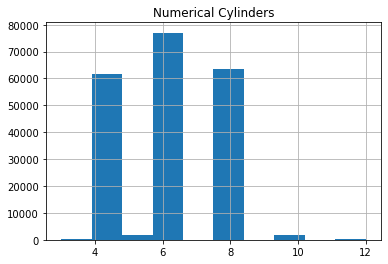

In [5]:
#Turn Cylinder column from string to numeric
auto_data['cyl'] = auto_data['cylinders']
auto_data['cyl'] = auto_data['cyl'].replace('other', np.nan)
auto_data['cyl'] = auto_data['cyl'].astype(str).str[0:2]
auto_data['cyl'] = auto_data['cyl'].str.strip()
auto_data['cyl'] = auto_data['cyl'].replace('na', np.nan)
auto_data['cyl'] = pd.to_numeric(auto_data['cyl'])
auto_data['cylinders']= auto_data['cyl']
auto_data= auto_data.drop(['cyl'], axis=1)

#plot Cylinders
plt.title("Numerical Cylinders")
hist = auto_data.cylinders.hist(bins=10)

In [6]:
#Neaten Strings
#Fix manufacturer
auto_data['manufacturer']= auto_data['manufacturer'].str.title().str.strip()
auto_data['manufacturer']= auto_data['manufacturer'].str.replace(' ', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Land-Rover', 'Rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Rover', 'Land-Rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Porche', 'Porsche')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('---', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('--', '-')


#Fix model
auto_data['model']= auto_data['model'].str.title().str.strip()
auto_data['model']= auto_data['model'].str.replace(' ', '-')
auto_data['model']= auto_data['model'].str.replace('---', '-')
auto_data['model']= auto_data['model'].str.replace('--', '-')

#fix Type
auto_data['type']= auto_data['type'].str.title().str.strip()

#States are state codes
auto_data['state'] = auto_data['state'].str.upper().str.strip()

#If no paint color is given its unlisted and its unrealistc to try to impute it
auto_data['paint_color'] = auto_data['paint_color'].fillna('unlisted')


In [7]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261705 entries, 2 to 539752
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            261705 non-null  int64  
 1   region        261705 non-null  object 
 2   price         261705 non-null  int64  
 3   year          261705 non-null  float64
 4   manufacturer  252526 non-null  object 
 5   model         261705 non-null  object 
 6   condition     261705 non-null  object 
 7   cylinders     206443 non-null  float64
 8   fuel          261683 non-null  object 
 9   odometer      261705 non-null  float64
 10  title_status  261699 non-null  object 
 11  transmission  261515 non-null  object 
 12  drive         221851 non-null  object 
 13  size          124791 non-null  object 
 14  type          226891 non-null  object 
 15  paint_color   261705 non-null  object 
 16  state         261705 non-null  object 
 17  lat           259496 non-null  float64
 18  long

### Cleaning Rules: Common Sense

We want to use data that will help us predict the price of a good condition vehicle. Therefore we are not looking at million dollar superluxury cars nor are we looking at vehicle that are being sold for scraps or as junkers.

* This study is not looking at Super luxury cars/ antique cars: 
    * None of the vehicles should have a price greater than half a million
* This study is not looking at motorbikes or busses 
    * We don't need Harley Davidson’s or Hennessey’s 
* This study is not looking at junker cars so we do not need vehicles:
    * Priced at 1000 dollars or less
    * That have over a half million miles on them
    * In poor condition or have a title status equal or worse than salvage
    * Are over than 10 years old (we are also not looking at antique cars)
* Cleaning obvious errors:
    * We are looking at used vehicles so the vehicles age should be greater than 1 year

In [8]:
# If we are dealing with a vehicle with over a half milion miles we have more problem
auto_data = auto_data[(auto_data.odometer< 500000)] 


#This study is not look at eather junkers or antiques so 
#a: age has to be greater than 0 and less than 11 years
#b: price has to be greater than $100 and less than half million
#c: mileage has to be greater than or equal to 0 and less than half million

auto_data['age'] = 2020-auto_data['year']
auto_data = auto_data[(auto_data.age > 0) & (auto_data.age <= 10)]
auto_data = auto_data[(auto_data.price >= 100) & (auto_data.price <= 500000)]
auto_data = auto_data[(auto_data.odometer >= 0) & (auto_data.odometer <= 500000)]


print(f"Maximum price: $ {auto_data.price.max()} \nMinimum price: $ {auto_data.price.min()} ")
print(f"Maximum age:  {auto_data.age.max()} years \nMinimum age: {auto_data.age.min()} years ")
print(f"Maximum mileage: {auto_data.odometer.max()} \nMinimum mileage: {auto_data.odometer.min()} ")


Maximum price: $ 479000 
Minimum price: $ 100 
Maximum age:  10.0 years 
Minimum age: 1.0 years 
Maximum mileage: 499103.0 
Minimum mileage: 0.0 


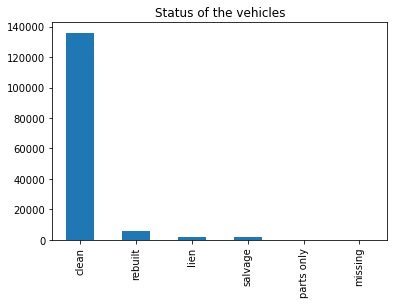

In [9]:
#This study is not look junkers so condition and title_ status is better than salvage

#See Status of Vehicles
auto_data.title_status.value_counts().plot.bar()
plt.title("Status of the vehicles")
plt.show()


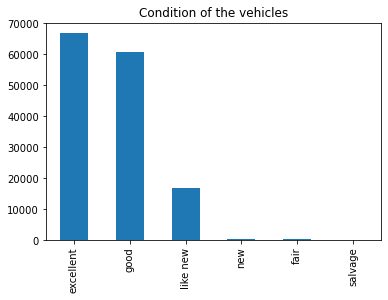

In [10]:
#See Condition of Vehicles

auto_data.condition.value_counts().plot.bar()
plt.title("Condition of the vehicles")
plt.show()

In [11]:
#This study does not look junkers so condition and title_ status is better than salvage

idx1 = auto_data[auto_data["condition"] == "salvage"].index

for w in ["salvage","lien","missing","parts only", 'rebuilt']:
    idx2 = auto_data[auto_data["title_status"] == w].index
    idx1 = idx1.union(idx2)
    
auto_data.drop(idx1, axis = 0, inplace = True)

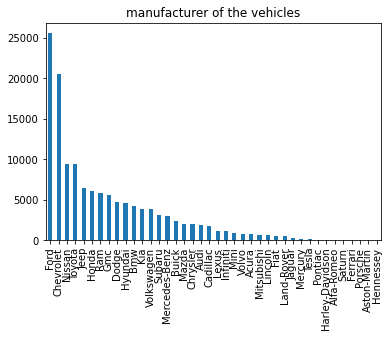

In [12]:
#We are not looking at motorbikes

#Graph manufacturers

auto_data.manufacturer.value_counts().plot.bar()
plt.title("manufacturer of the vehicles")
plt.show()

In [13]:

#We are not looking at motorbikes
auto_data = auto_data[auto_data.manufacturer != 'Harley-Davidson']
auto_data = auto_data[auto_data.manufacturer != 'Hennessey']

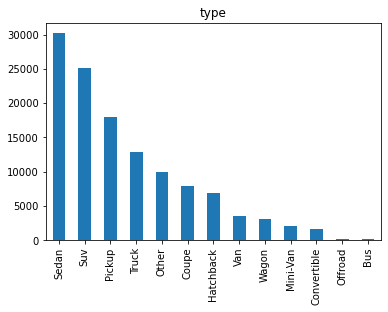

In [14]:
#We are not looking at buses
#Graph type

auto_data.type.value_counts().plot.bar()
plt.title("type")
plt.show()

In [15]:
#We are not looking at bus
auto_data = auto_data[auto_data.type != 'bus']


In [16]:
#Create Make Model Model Year Key (Useful for later)
auto_data['mmy_a']=auto_data['manufacturer']+' '+auto_data['model']+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a']=auto_data['mmy_a'].str.title()

auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model'].str.split(' ').str[0]+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a2']=auto_data['mmy_a2'].str.title()


In [17]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 2 to 539744
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            135864 non-null  int64  
 1   region        135864 non-null  object 
 2   price         135864 non-null  int64  
 3   year          135864 non-null  float64
 4   manufacturer  133027 non-null  object 
 5   model         135864 non-null  object 
 6   condition     135864 non-null  object 
 7   cylinders     97736 non-null   float64
 8   fuel          135861 non-null  object 
 9   odometer      135864 non-null  float64
 10  title_status  135858 non-null  object 
 11  transmission  135734 non-null  object 
 12  drive         112965 non-null  object 
 13  size          53221 non-null   object 
 14  type          121915 non-null  object 
 15  paint_color   135864 non-null  object 
 16  state         135864 non-null  object 
 17  lat           134746 non-null  float64
 18  long

In [18]:
auto_data.describe()

,id,price,year,cylinders,odometer,lat,long,age
count,1.358640e+05,135864.000000,135864.000000,97736.000000,135864.000000,134746.000000,134746.000000,135864.000000
mean,7.087761e+09,16985.193613,2014.185619,5.875194,78798.991675,37.930269,-90.852293,5.814381
std,5.017708e+06,10949.604972,2.571134,1.591569,50567.452874,5.354238,15.904711,2.571134
min,7.065765e+09,100.000000,2010.000000,3.000000,0.000000,-51.393200,-166.377000,1.000000
25%,7.085130e+09,9900.000000,2012.000000,4.000000,37704.000000,33.786500,-96.880800,4.000000
50%,7.088878e+09,15200.000000,2014.000000,6.000000,73298.000000,38.360300,-84.510000,6.000000
75%,7.091976e+09,21900.000000,2016.000000,8.000000,111700.750000,42.064100,-80.253800,8.000000
max,7.093536e+09,450000.000000,2019.000000,12.000000,499103.000000,84.514800,94.124800,10.000000


Save Data

In [19]:
sub_file = 'data'
new_file = 'auto_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data.to_csv(new_file_name_path, index=False)

## Categorical Data
We want data on what segment the vehicle is in as that might change the prices significantly.
We got this data from back4app an open data source that uses categories based on US department of transportation.

Website: https://www.back4app.com/database/back4app/car-make-model-dataset

In [20]:
#Get Categorical Data

where = urllib.parse.quote_plus("""
{
    "Category": {
        "$exists": true
    },
    "Year": {
        "$gte": 2010
    }
}
""")
url = 'https://parseapi.back4app.com/classes/Carmodels_Car_Model_List?limit=5000&where=%s' % where
headers = {
    'X-Parse-Application-Id': 'pozCwVISt2yfzi2wJjwo0JiMIJclsUAOchP4AuJO', # This is your app's application id
    'X-Parse-REST-API-Key': 'Jtc8r91VIJOizG8ReKkaseZcugQjAx4vG1WKbJye' # This is your app's REST API key
}
data_json = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need


#import collections

In [21]:
#the above data was too nested a dictionaries listed in a list that was in a list that was a dictionary
print(type(data_json))
list_values = [ v for v in data_json.values() ] #undoes dictionary

list_value_items = [y for x in list_values for y in x] # undoes list

cat_data = pd.DataFrame.from_dict(list_value_items) #turns list of dictionaries into data frame


<class 'dict'>


In [22]:
#we don't need object id or created at
cat_data= cat_data.drop(['objectId', 'createdAt'], axis=1)
print(cat_data.head())
cat_data.describe()

   Year       Make         Model            Category                 updatedAt
0  2020       Audi            Q3                 SUV  2020-01-27T20:44:17.665Z
1  2020  Chevrolet        Malibu               Sedan  2020-01-27T20:44:17.665Z
2  2020   Cadillac  Escalade ESV                 SUV  2020-01-27T20:44:17.665Z
3  2020  Chevrolet      Corvette  Coupe, Convertible  2020-01-27T20:44:17.665Z
4  2020      Acura           RLX               Sedan  2020-01-27T20:44:17.665Z


,Year
count,4082.000000
mean,2015.034052
std,3.028828
min,2010.000000
25%,2012.000000
50%,2015.000000
75%,2018.000000
max,2020.000000


In [23]:
#Neaten Strings
cat_data['Make'] = cat_data['Make'].str.title().str.strip()
cat_data['Make']= cat_data['Make'].str.replace(' ', '-') 
cat_data['Model'] = cat_data['Model'].str.title().str.strip()
cat_data['Model']= cat_data['Model'].str.replace(' ', '-') 

#Create Key
cat_data['mmy']=cat_data['Make']+' '+cat_data['Model'].str.strip()+ ' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy']= cat_data['mmy'].str.title()

cat_data['mmy2']=cat_data['Make']+' '+cat_data['Model'].str.split(' ').str[0]+' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy2']= cat_data['mmy2'].str.title()



In [24]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4082 entries, 0 to 4081
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       4082 non-null   int64 
 1   Make       4082 non-null   object
 2   Model      4082 non-null   object
 3   Category   4082 non-null   object
 4   updatedAt  4082 non-null   object
 5   mmy        4082 non-null   object
 6   mmy2       4082 non-null   object
dtypes: int64(1), object(6)
memory usage: 223.4+ KB


In [25]:

#Save Categorical Data
sub_file = 'data'
new_file = 'cat_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
cat_data.to_csv(new_file_name_path, index=False)

## Find MSRP data
The original price of the car will heavily effect the older price. Let's bring that out.
This data is a downloaded file from https://www.kaggle.com/CooperUnion/cardataset . This data was obtained by scraping edmunds (a car rating website) and twitter.

In [26]:
# Create the list of file names: filenames
file ='msrp.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
msrp_data= pd.read_csv(file_name_path)

#Open data
msrp_data.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,mmy,mmy2
0,Bmw,1-Series-M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135,Bmw 1-Series-M 2011,Bmw 1-Series-M 2011
1,Bmw,1-Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650,Bmw 1-Series 2011,Bmw 1-Series 2011
2,Bmw,1-Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350,Bmw 1-Series 2011,Bmw 1-Series 2011
3,Bmw,1-Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450,Bmw 1-Series 2011,Bmw 1-Series 2011
4,Bmw,1-Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500,Bmw 1-Series 2011,Bmw 1-Series 2011


In [27]:
#From the previous cleaning rules we eliminate vehicles with value of over half a million and an age over 10 years

print(f"Maximum MSRP: {msrp_data.MSRP.max()} \nMinimum MSRP: {msrp_data.MSRP.min()} ")
# If we are dealing with a vehicle with an MSRP over half milion miles we have more problem
msrp_data = msrp_data[(msrp_data.MSRP< 500000 )] 
print(f"Maximum Year: {msrp_data.Year.max()} \nMinimum Year: {msrp_data.Year.min()} ")
# We only need vehicles with over a 2009 MY
msrp_data = msrp_data[(msrp_data.Year> 2009 )] 



Maximum MSRP: 497650 
Minimum MSRP: 11965 
Maximum Year: 2017 
Minimum Year: 2010 


In [28]:
# Clean Strings/ Neaten Strings

msrp_data['Make']= msrp_data['Make'].str.title().str.strip()
msrp_data['Make']= msrp_data['Make'].str.replace(' ', '-')
msrp_data['Model']= msrp_data['Model'].str.title().str.strip()
msrp_data['Model']= msrp_data['Model'].str.replace(' ', '-')

#Make Keys
msrp_data['mmy']=msrp_data['Make']+' '+msrp_data['Model']+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy']= msrp_data['mmy'].str.title()
msrp_data['mmy2']=msrp_data['Make']+' '+msrp_data['Model'].str.split(' ').str[0]+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy2']= msrp_data['mmy2'].str.title()



In [29]:
MSRP_dict = msrp_data.groupby(['Make', 'Model', 'Year', 'mmy', 'mmy2'])['MSRP'].mean().reset_index()

In [30]:
MSRP_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Make    1363 non-null   object 
 1   Model   1363 non-null   object 
 2   Year    1363 non-null   int64  
 3   mmy     1363 non-null   object 
 4   mmy2    1363 non-null   object 
 5   MSRP    1363 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 64.0+ KB


In [31]:
sub_file = 'data'
new_file = 'msrp.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
msrp_data.to_csv(new_file_name_path, index=False)

# Merging Data

#### Mapping Categorical and MSRP data to the auto from Craig's list

First the MMY
* Automobiles models are referenced by its a) manufacture b) model name, and C) model year (otherwise known as the MMY)
* Each mmy has an average MSRP to go with it and a specific groups of catehories can be in 
    * (ex a camry can be sedan or hatchback it can't be a pickup)
* We will therefore use the MMYas a key to map the MSRP and category to the main data set

Issue: Model names of automobile
* The trim of a model is referencing a set of additional features comes with (example Camry Lux has leather seats)
* The trim changes the price of a vehicle
* Therefore sometimes sellers will add the trim after the model design to give a better idea of what they are selling
* This leads to the model name not being consistent across tables.

Fixing the Issue
* To ensure better mapping we will therefore use 2 keys 
* The first key will match the full name of the model for the mmy
* The second key will match the first word name of the model for the mmy
* We will try to map to first the key if a map isn't reached we use the results from the second key.
* both keys include the manufacturer and model year



In [32]:
#Create Dictionaries to map with


#create mmy key2 for autos
auto_data['model2']= auto_data['model'].str.split(' ').str[0]
auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model2']+ ' '+ auto_data['year'].astype(int).astype(str)

#auto_dictionary
auto_dict= auto_data[['manufacturer', 'model', 'year', 'mmy_a', 'mmy_a2']].drop_duplicates(keep='last')

#MSRP_dictionary_1 has only the first key
MSRP_dict1 = MSRP_dict[['mmy', 'MSRP']]

#MSRP_dictionary_2 has only the second key
MSRP_dict2= MSRP_dict[['mmy2', 'MSRP']]
MSRP_dict2['MSRP_vague'] = MSRP_dict2['MSRP']
MSRP_dict2= MSRP_dict2.drop(columns= ['MSRP'])



C:\Users\Tiki\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [33]:
#Merge auto_dict and MSRP dictionary 1 into df1 using the 1st key
df1= pd.merge(auto_dict, MSRP_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )
#Merge dictionary3 and MSRP dictionary 2 into auto_msrp_dictionary using the second key
a_m_dict= pd.merge(df1, MSRP_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#fill any null results in MSRP from first key map by results in second key
a_m_dict['MSRP']=a_m_dict['MSRP'].fillna(a_m_dict['MSRP_vague']) 

#drop duplicates
a_m_dict= a_m_dict[['mmy_a', 'mmy', 'mmy2','MSRP']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [34]:
#Cat_dictionary_1 has only the first key
cat_dict= cat_data[['Make', 'Model', 'Year', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['Make', 'Model', 'Year', 'mmy', 'mmy2'], keep='last')
cat_dict1 = cat_dict[['mmy', 'Category']]


#Cat_dictionary_2 has only the second key
cat_dict2= cat_dict[['mmy2', 'Category']]
cat_dict2['Category_vague'] = cat_dict2['Category']
cat_dict2= cat_dict2.drop(columns= ['Category'])


C:\Users\Tiki\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
#Merge auto dictionary and cat dictionary 1 into dictionary into df1 using the first key
df1= pd.merge(auto_dict, cat_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )

#Merge dictionary3 and cat dictionary 2 into auto_cat_dictionary using the second key
a_c_dict= pd.merge(df1, cat_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#Fill in blanks in the Category left from the first key with results from the second key (if any)
a_c_dict['Category']=a_c_dict['Category'].fillna(a_c_dict['Category_vague']) 


#drop duplicates 
a_c_dict= a_c_dict[['mmy_a', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [36]:
print(a_c_dict.info())
print(a_m_dict.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24598 entries, 0 to 26063
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mmy_a     20815 non-null  object
 1   mmy       4082 non-null   object
 2   mmy2      4082 non-null   object
 3   Category  5973 non-null   object
dtypes: object(4)
memory usage: 960.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21826 entries, 0 to 23291
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mmy_a   20815 non-null  object 
 1   mmy     1363 non-null   object 
 2   mmy2    1363 non-null   object 
 3   MSRP    1868 non-null   float64
dtypes: float64(1), object(3)
memory usage: 852.6+ KB
None


In [37]:
#Merge Cat and MSRP
#We still have two keys mmy_a and mmy

a_m_dict_1= a_m_dict[['mmy_a', 'MSRP']].dropna()
a_m_dict_2= a_m_dict[['mmy', 'MSRP']].dropna()
a_m_dict_3= a_m_dict[['mmy2', 'MSRP']].dropna()

a_m_dict_2= a_m_dict_2.rename(columns={"MSRP": "MSRP_2"})
a_m_dict_3= a_m_dict_3.rename(columns={"MSRP": "MSRP_3"})


In [38]:
#Merge a_c and a_m dict on first key
df1= pd.merge(a_c_dict, a_m_dict_1, on='mmy_a', how='outer')


In [39]:
#Merge a_c and a_m dict on second key
df2 = pd.merge(df1,  a_m_dict_2, left_on='mmy', right_on='mmy', how='outer' )


In [40]:
#Merge a_c and a_m dict on third key
a_m_c_dict = pd.merge(df2,  a_m_dict_3, on='mmy2', how='outer' )
a_m_c_dict.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 25406 entries, 0 to 25405
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mmy_a     20815 non-null  object 
 1   mmy       4486 non-null   object 
 2   mmy2      4486 non-null   object 
 3   Category  5973 non-null   object 
 4   MSRP      858 non-null    float64
 5   MSRP_2    1363 non-null   float64
 6   MSRP_3    1363 non-null   float64
dtypes: float64(3), object(4)
memory usage: 1.6+ MB


In [41]:
#Fill in blanks in the MSRP left from 1st key with results from the 2nd and 3rd key (if any)
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_2']) 
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_3']) 

#drop duplicates
a_m_c_dict= a_m_c_dict[['mmy_a', 'MSRP', 'Category']].drop_duplicates(subset=['mmy_a'], keep= 'last' )

#drop if missing 'mmy_a'
a_m_c_dict = a_m_c_dict[a_m_c_dict['mmy_a'].notna()]


Merge Dictionaries with auto

In [42]:
z= pd.merge(auto_data, a_m_c_dict, on='mmy_a', how='left')
z.info()
auto_data= z

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 0 to 135863
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            135864 non-null  int64  
 1   region        135864 non-null  object 
 2   price         135864 non-null  int64  
 3   year          135864 non-null  float64
 4   manufacturer  133027 non-null  object 
 5   model         135864 non-null  object 
 6   condition     135864 non-null  object 
 7   cylinders     97736 non-null   float64
 8   fuel          135861 non-null  object 
 9   odometer      135864 non-null  float64
 10  title_status  135858 non-null  object 
 11  transmission  135734 non-null  object 
 12  drive         112965 non-null  object 
 13  size          53221 non-null   object 
 14  type          121915 non-null  object 
 15  paint_color   135864 non-null  object 
 16  state         135864 non-null  object 
 17  lat           134746 non-null  float64
 18  long

###  Find State data
We can use geographic data to find other data we need. Two things that common wisdom suggests effect car prices 
1) Amount of money people make 
2) gas prices 
We can find the average income people make in the state as well as the aproximate gas prices when this Craigslist dataset was collected.

Gas prices come from AAA which shows the daily average gas prices for a state. They do not store this data so the data was scraped from the next nearest date available from the scraping of the Craiglist data which was Feb 22 https://web.archive.org/web/20200226222808/https://gasprices.aaa.com/state-gas-price-averages/
This data for household income by state was from https://dqydj.com/average-income-by-state-median-top-percentiles/ a place that holds financial data and that is recommend by the WSJ and the NYT.


## Add State Data

In [43]:


#get_state_data
state_file ='state_data.csv'

print('p')
file_name_path = os.path.join(basepath, 'data', state_file)
state_data= pd.read_csv(file_name_path)
state_data.info()
#Open data


p
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   State                    51 non-null     object 
 1   Avg_Gas_Price            51 non-null     float64
 2   Division                 51 non-null     object 
 3   Median Household Income  51 non-null     float64
 4   State_Code               51 non-null     object 
dtypes: float64(2), object(3)
memory usage: 2.1+ KB


In [44]:
#merge_with_state_data
auto_data_m= auto_data.merge(state_data, left_on='state', right_on='State_Code')
auto_data_m.info()
auto_data = auto_data_m

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 0 to 135863
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                97736 non-null   float64
 8   fuel                     135861 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    112965 non-null  object 
 13  size                     53221 non-null   object 
 14  type

In [45]:
#save data

new_file = 'auto_data_m_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data_m.to_csv(new_file_name_path, index=False)

## Impute the Data

When looking at the vehicles we note that there are lot of nulls about the vehicles features (example: the number of cylinders, drive, transmission, size, and type of vehicle). When buying a vehicle these are things you would usually ask the seller because it does effect the price of the vehicle (a vehicle with more cylinders usually is of higher value than one is of less). 

While these features can differ within a make (aka brand here listed as manufacturer) model, and model year (MMY) of a vehicle we can narrow down what the feature should be given the other features of the vehicle. For example: a  2016 Jaguar F-Type  can be all wheel drive or all-wheel drive ,  be a coupe or convertible, be automatic or manual transmission. You would think there be at least 8 configurations of the F-type.   However only a certain grouping of configurations (called Trims) that these vehicle are sold as.  There are actually on 6 configurations for the 2016 Jaguar F-Type because you can only get a manual transmission with rear wheel drive. 

If we don't have enough data to impute the vehicle given MMY and the other features we can determine the feature given its MMY. This is because A) There is usually a most popular trim for the MMY of a vehicle. B) Some features do not differ within MMY for example the 2017 Honda Accord only has 4 cylinders. 

If MMY does not give us a value we can look at just the make and model. The most likely configuration for model does change for each model year. However the trims of these features only change for every redesign of the model which does not happen every model year. So after looking a MMY we look at make model.


In [46]:
file = 'auto_data_m_cl.csv'

sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


In [47]:
auto_data['type']= auto_data['type'].str.title().str.strip()
print(auto_data['type'].value_counts())
print(auto_data.isnull().sum())

Sedan          30180
Suv            25195
Pickup         18029
Truck          12821
Other          10044
Coupe           7996
Hatchback       6954
Van             3599
Wagon           3052
Mini-Van        2128
Convertible     1624
Offroad          156
Bus              137
Name: type, dtype: int64
id                              0
region                          0
price                           0
year                            0
manufacturer                 2837
model                           0
condition                       0
cylinders                   38128
fuel                            3
odometer                        0
title_status                    6
transmission                  130
drive                       22899
size                        82643
type                        13949
paint_color                     0
state                           0
lat                          1118
long                         1118
age                             0
mmy_a                 

In [48]:
auto_data['cylinders'] = pd.to_numeric(auto_data['cylinders'])

q1 = auto_data
#Create possible Trim configurations look at cylinders, drive and transmission
q1['mmy_a_d_t'] = q1['mmy_a'].astype(str)+' '+q1['drive'].astype(str)+' '+q1['transmission'].astype(str)
q1['mmy_a_t'] = q1['mmy_a'].astype(str)+' '+q1['transmission'].astype(str)
q1['mmy_a_d'] = q1['mmy_a'].astype(str)+' '+q1['drive'].astype(str)

#Remove trim if there is missing value in the grouping
q1.loc[(q1['transmission'].isna()), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['transmission'].isna()), 'mmy_a_t' ] = np.nan
q1.loc[(q1['transmission'].str.contains('nan', na= False)), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['transmission'].str.contains('nan', na= False)), 'mmy_a_t' ] = np.nan
q1.loc[(q1['drive'].isna()), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['drive'].isna()), 'mmy_a_d' ] = np.nan
q1.loc[(q1['drive'].str.contains('nan', na= False)), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['drive'].str.contains('nan', na= False)), 'mmy_a_d' ] = np.nan

#Create Make Model Category
q1['mm']=q1['manufacturer'].astype(str)+' '+q1['model'].astype(str)
q1['mm2']=q1['manufacturer'].astype(str)+' '+q1['model2'].astype(str)


In [49]:
def comp_F(q1):
    q1['cylinders1'] = q1['cylinders']
    q1['size1'] = q1['size']
    q1['Category1'] = q1['Category']
    q1['type1'] = q1['type']
    q1['drive1'] = q1['drive']
    q1['transmission1'] = q1['transmission']
    
def comp_D(q1):
    q1['cylinders'] = q1['cylinders'].fillna(q1['cylinders1'])
    q1['size'] = q1['size'].fillna(q1['size1'])
    q1['Category'] = q1['Category'].fillna(q1['Category1'])
    q1['type'] = q1['type'].fillna(q1['type1'])
    q1['drive'] = q1['drive'].fillna(q1['drive1'])
    q1['transmission1'] = q1['transmission'].fillna(q1['transmission1'])

In [50]:
#impute by trim
comp_F(q1)
q1['MSRP1'] = q1['MSRP']

print('Before imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


q1['MSRP1'] = q1.groupby(['mmy_a', 'cylinders'], sort=False)['MSRP'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['cylinders1'] = q1.groupby(['mmy_a_d_t'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mmy_a_d_t'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mmy_a_d_t'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mmy_a_d_t'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mmy_a_t'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mmy_a_d'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

q1['MSRP'] = q1['MSRP'].fillna(q1['MSRP1'])
comp_D(q1)

print('After trim imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category', 'MSRP' ]].isnull().sum())



Before imputation the number of nulls are:
cylinders       38128
size            82643
type            13949
drive           22899
transmission      130
Category        97038
dtype: int64
After trim imputation the number of nulls are:
cylinders        26101
size             53662
type              7062
drive             7192
transmission       130
Category         97038
MSRP            121663
dtype: int64


In [51]:
#impute by Make Model Model Year
comp_F(q1)
cols = ['cylinders1', 'size1', 'Category1', 'type1', 'drive1', 'transmission1']

q1['MSRP1'] = q1.groupby(['mmy_a'], sort=False)['MSRP'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['cylinders1'] = q1.groupby(['mmy_a'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mmy_a'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mmy_a'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mmy_a'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mmy_a'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mmy_a'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

q1['MSRP'] = q1['MSRP'].fillna(q1['MSRP1'])
comp_D(q1)
print('After manufacture model and model year  imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


After manufacture model and model year  imputation the number of nulls are:
cylinders       18777
size            40472
type             2556
drive            6389
transmission      130
Category        97038
dtype: int64


In [52]:
## Is this needed? 

#impute by Make Model
comp_F(q1)
q1['cylinders1'] = q1.groupby(['mm'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mm'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mm'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mm'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mm'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mm'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
comp_D(q1)
print('After manufacture model and model year  imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


After manufacture model and model year  imputation the number of nulls are:
cylinders       12907
size            26774
type             1253
drive            3228
transmission      130
Category        95929
dtype: int64


In [53]:
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135861 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [54]:
#Drop Excess Variables that were used for imputation
q1 = q1.drop(columns=['cylinders1', 'size1','Category1','type1' , 'drive1', 'transmission1', 'MSRP1'], axis=1 )
q1 = q1.drop(columns=['mmy_a', 'mmy_a2','mmy_a_d_t','mmy_a_d' , 'mmy_a_t', 'mm', 'mm2', 'model2'], axis=1 )

In [55]:
#impute longitude and latitude from state
q1['lat'] = q1.groupby(['state'], sort=False)['lat'].apply(lambda x: x.fillna(x.mode().iloc[0]))
q1['long'] = q1.groupby(['state'], sort=False)['long'].apply(lambda x: x.fillna(x.mode().iloc[0]))

#impute fuel
q1['fuel'] = q1['fuel'].fillna(q1['fuel'].mode()[0])
q1['MSRP'] = q1['MSRP'].fillna(0)
print(q1.isnull().sum())

id                             0
region                         0
price                          0
year                           0
manufacturer                2837
model                          0
condition                      0
cylinders                  12907
fuel                           0
odometer                       0
title_status                   6
transmission                 130
drive                       3228
size                       26774
type                        1253
paint_color                    0
state                          0
lat                            0
long                           0
age                            0
MSRP                           0
Category                   95929
State                          0
Avg_Gas_Price                  0
Division                       0
Median Household Income        0
State_Code                     0
dtype: int64


In [56]:
#If no paint color is given its unlisted and its unrealistc to try to impute it
q1['paint_color'] = q1['paint_color'].fillna('unlisted')

In [57]:
q1['Avg_Mileage'] = q1['odometer']/ q1['age']
q1['resid'] = q1['MSRP']/ q1['price']
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135864 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [58]:

categorical_columns = q1.select_dtypes(exclude=['int64', 'float']).columns.tolist()

for col in categorical_columns:
    q1[col] = q1[col].astype('category')
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       135864 non-null  int64   
 1   region                   135864 non-null  category
 2   price                    135864 non-null  int64   
 3   year                     135864 non-null  float64 
 4   manufacturer             133027 non-null  category
 5   model                    135864 non-null  category
 6   condition                135864 non-null  category
 7   cylinders                122957 non-null  float64 
 8   fuel                     135864 non-null  category
 9   odometer                 135864 non-null  float64 
 10  title_status             135858 non-null  category
 11  transmission             135734 non-null  category
 12  drive                    132636 non-null  category
 13  size                     109090 non-null  ca

Save Data

In [59]:
#save data

new_file = 'auto_data_merged_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
q1.to_csv(new_file_name_path, index=False)

## Exploratory Data getting rid of outliers

We do not want any outliers in our dataset before we make any calculations. That said:
1) We already eliminated a lot of the ouliers due to the common sense cleaning rules.
2) The values for price, and mileage in the vehicle is a skew distribution with a long tail and not a normal distribution.

Therefore we are conservative in our deletion of outliers.

We beleive we should investigate four outliers when:
* The 98the percentile and the 99th percentile differ by larger than 1 standard deviation. Then all values greater than the 98th percentile are likely to be outliers.
* Similarly elimiate if 99th percentile and maximum differ by larger than 1 standard deviation. Then all values greater than the 99th percentile are likely to be outliers.

The results of this investigation is that price, odometer, residual and average mileage needed to be investigaated.

We did not want to get rid of any vehicles that are in the same price range of the Teslas so we eliminated vehicles


In [60]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_merged_cl.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto trimmed price.ipynb', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2_sqrt.ipynb', 'auto_clean_copy3 State vs Region.ipynb', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_deletion.png', 'figures', 'Figx_ModelComparison.png', 'Figx_ModelComparison_MPE.png', 'Figx_ModelComparison_Std.png', 'Figx_Model_Comparison_RMSLE.png', 'Figx_Model_Comparison_std.png', 'Scrap.ipynb']


In [61]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135864 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [62]:
auto_data['resid'] = auto_data['resid'].fillna(0)
auto_data.describe(percentiles= [0.05, .25, .5, .75, 0.95,  0.98, 0.99] )
# Rule if the maximum number of the 98the percentile and the 99th percentile differ by larger than 1 std then you elimate those numbers
# Similarly elimiate if 99th percentile and maximum is one standard deviation away elimate to 99th percentile


,id,price,year,cylinders,odometer,lat,long,age,MSRP,Avg_Gas_Price,Median Household Income,Avg_Mileage,resid
count,1.358640e+05,135864.000000,135864.000000,122957.000000,135864.000000,135864.000000,135864.000000,135864.000000,135864.000000,135864.000000,135864.000000,135864.000000,135864.000000
mean,7.087761e+09,16985.193613,2014.185619,5.732671,78798.991675,37.941084,-90.792730,5.814381,3401.706963,2.562033,67037.229546,13844.548073,0.357715
std,5.017708e+06,10949.604972,2.571134,1.578850,50567.452874,5.346003,15.886272,2.571134,10737.804762,0.390233,9945.915390,7710.152579,3.584072
min,7.065765e+09,100.000000,2010.000000,3.000000,0.000000,-51.393200,-166.377000,1.000000,0.000000,2.150000,44092.000000,0.000000,0.000000
5%,7.077191e+09,4900.000000,2010.000000,4.000000,12000.000000,29.579100,-121.430000,2.000000,0.000000,2.160000,53021.000000,3800.295000,0.000000
25%,7.085130e+09,9900.000000,2012.000000,4.000000,37704.000000,33.786500,-96.774100,4.000000,0.000000,2.360000,58150.000000,9036.000000,0.000000
50%,7.088878e+09,15200.000000,2014.000000,6.000000,73298.000000,38.406650,-84.473300,6.000000,0.000000,2.400000,66882.000000,12833.333333,0.000000
75%,7.091976e+09,21900.000000,2016.000000,6.000000,111700.750000,42.065625,-80.240000,8.000000,0.000000,2.680000,73900.000000,17279.025000,0.000000
95%,7.093227e+09,34900.000000,2018.000000,8.000000,166997.750000,45.488100,-72.530000,10.000000,29233.157895,3.490000,86800.000000,26894.500000,2.058923
98%,7.093359e+09,43400.000000,2019.000000,8.000000,193675.940000,47.699774,-71.299426,10.000000,39699.000000,3.490000,87264.000000,33500.000000,2.799825


* Rule if the maximum number of the 98, 99 percentile differ by larger than 1 std you investigate
    * The results of this investigation is in price, odometer and average mileage
* Similarly we check if adding 98 percentile + 1std is worth doing



C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


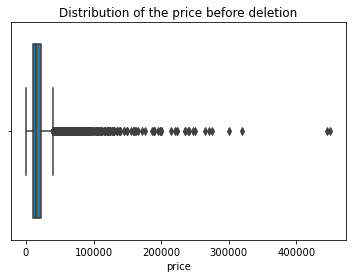

In [63]:
#Investigate price 
price = auto_data.price
sns.boxplot(price)
plt.savefig("Fig1_Price_before_deletion.png")
plt.title("Distribution of the price before deletion")
plt.show()
#so many outliers!

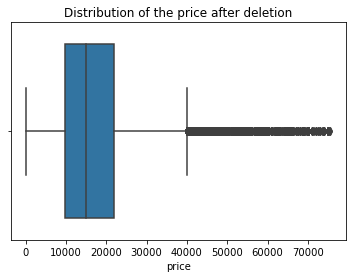

In [64]:
#We do not want to get rid of any vehicles that are in the same price range of the Teslas so we eliminated 
#vehicles under the maximum Tesla price


tes = auto_data[auto_data.manufacturer == 'Tesla']
Tes_price = tes['price'].max()
auto_data= auto_data[auto_data.price< Tes_price ]
price = auto_data.price
sns.boxplot(x=price)
plt.title("Distribution of the price after deletion")
plt.savefig("Fig2_Price_after_deletion.png")
plt.show()


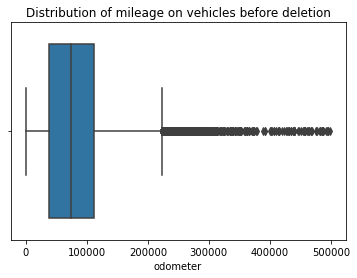

In [65]:
#Investigate Mileage
miles = auto_data.odometer
sns.boxplot(x=miles)
plt.title("Distribution of mileage on vehicles before deletion")
plt.show()
#so many outliers!

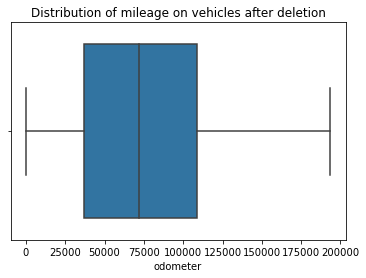

In [66]:
#We eliminate vehicles over the 98th percentile
odometer_p98 = auto_data['odometer'].quantile(.98)

auto_data= auto_data[auto_data.odometer< odometer_p98 ]
miles = auto_data.odometer
sns.boxplot(x=miles)
plt.title("Distribution of mileage on vehicles after deletion")
plt.show()

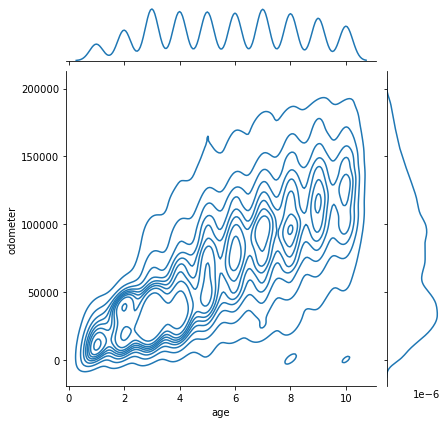

In [67]:
#Investigate Average Mileage
# Average Milage is the mileage divided by the age let's see that relationship 
g = sns.jointplot(x= 'age', y='odometer',data=auto_data , kind='kde')
_ = g.title = 'Age vs Mileage'
#We van see clustered Non Linear replationsip between age and mileage and some pretty clear boundries

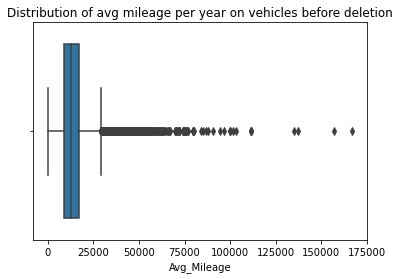

In [68]:
#Investigate Average Mileage using boxplot
avg_miles = auto_data.Avg_Mileage
sns.boxplot(x=avg_miles)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
#so many outliers!

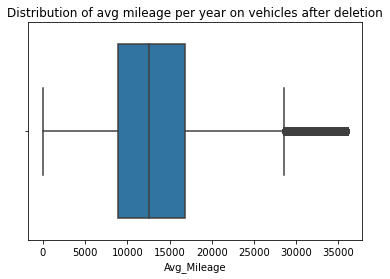

In [69]:
#We eliminate vehicles over the 99th percentile
avm_p99 = auto_data['Avg_Mileage'].quantile(.99)

auto_data= auto_data[auto_data.Avg_Mileage< avm_p99]
avg_miles = auto_data.Avg_Mileage
sns.boxplot(x=avg_miles)
plt.title("Distribution of avg mileage per year on vehicles after deletion")
plt.show()
plt.show()

We Eliminate the Superluxury Vehicles

In [70]:
#We are not loooking up superluxury cars aka
auto_data= auto_data[auto_data.manufacturer != 'Ferrari']
auto_data = auto_data[auto_data.manufacturer != 'Aston-Martin']

## EDA Explain some of the relationships within the data

In [71]:
auto_data.cylinders.value_counts()

4.0     45673
6.0     43745
8.0     28185
5.0       710
10.0      330
3.0       217
12.0        4
Name: cylinders, dtype: int64

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


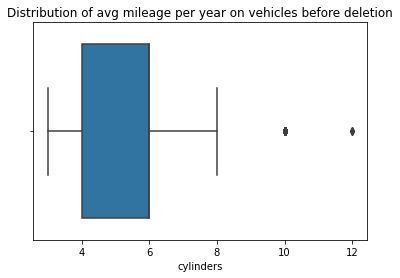

In [72]:
#Check Cylinders
#Investigate cylinders
auto_data['cylinders'] = pd.to_numeric(auto_data['cylinders'])
cylinders = auto_data.cylinders
sns.boxplot(cylinders)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
cylinders.value_counts()
#We eliminate 12 as it only has 8 values 
auto_data =  auto_data[auto_data['cylinders']<12]


<Figure size 1008x864 with 0 Axes>

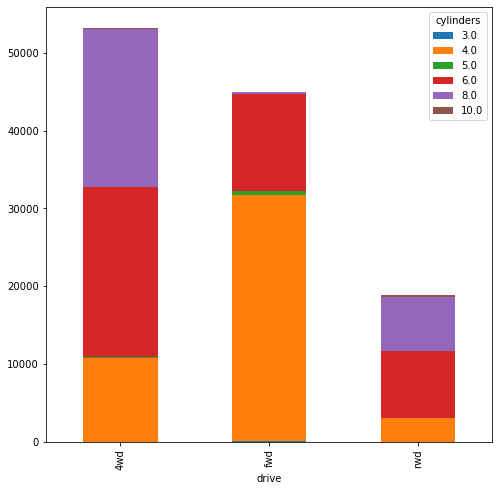

<Figure size 432x288 with 0 Axes>

In [73]:
#There is an interesting relationship between cylinders, and drive
size_type_table = pd.crosstab(index=auto_data["drive"], columns=auto_data["cylinders"])
plt.figure(figsize=(14,12))
size_type_table.plot(kind="bar",  figsize=(8,8), stacked=True)
plt.show()
plt.savefig("cylinder_drive.png")


<Figure size 1008x864 with 0 Axes>

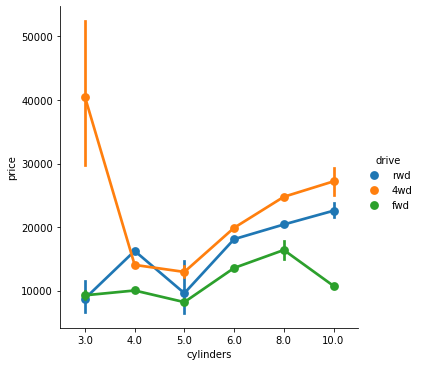

<Figure size 432x288 with 0 Axes>

In [74]:
#There is an interesting relationship between cylinders, drive, mileage and price
plt.figure(figsize=(14,12))
sns.catplot(x="cylinders", y="price", hue='drive', kind='point', data=auto_data)
plt.show()
plt.savefig("cylinder_drive_mileage_price.png")


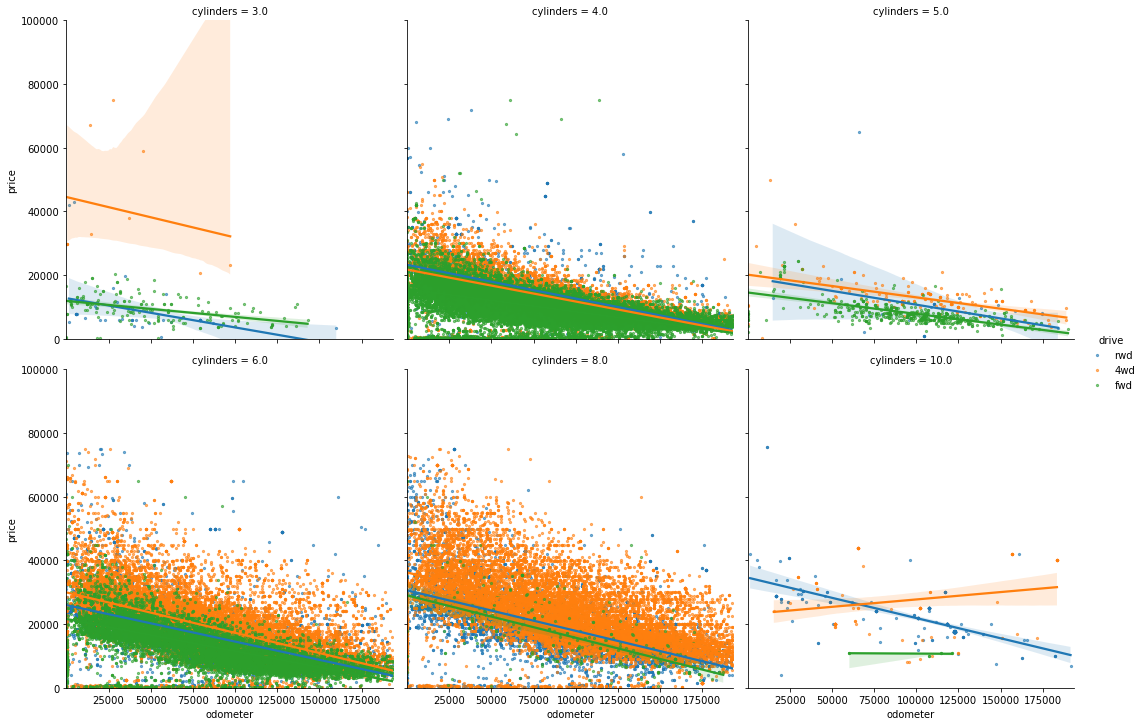

In [75]:
g = sns.lmplot(x= 'odometer', y='price', data=auto_data,  col="cylinders", hue='drive', col_wrap=3, scatter_kws={"alpha":.6, "s": 5})
g = (g.set( ylim=(0, 100000)))

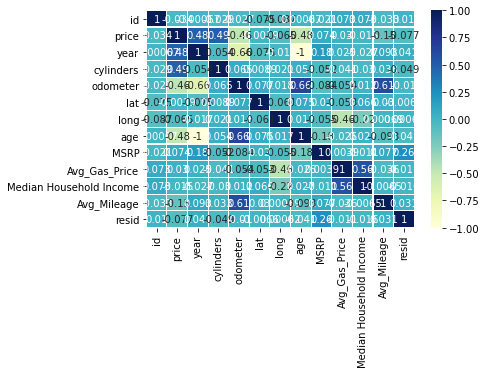

In [76]:
#check for overall correlation relationships

w1 = auto_data.select_dtypes(include=['int64', 'float'])
sns.heatmap(w1.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

#### Notes
High corelation linear
* Price , MSRP, 
* Price ,  cylinders
* MSRP , cylinders
* Residual,  cylinders
decent correlation 
* Price odometer
* price age
* age odometer (this does not make sense this should have stronger relationship)

In [77]:
# More visuals regarding the distributions are in eda3

## Cleaning Category/ type
* Category refers to the type of design of the vehicle ( examplesedan, hatchback), and it is something people take into consideration while buying a vehicle
* However the naming convention for this is non standard across manufactuers ("pickup" vs "truck" refers to the same type from Ford and GM respectively)
* Considering there are many users on Craigslist even though type is often in the description of a vehicle sold the naming convention would not be consistent from one user description to the next. 
* Since Category type is scraped from the user description means that type is inconsistent across the database

* A Singular third party from an automible expert in this case the USA government will give us a consistent naming convention across all vehicles
* However the goverment gives us a group of possible types a vehicle could be given make model model year

* By combining the user description and the third party categories we get a specific category for each vehicle which has a conistent naming convention across vehicles

* For the merge's we have we are going to check if the category within the description matches what the third party gave


In [78]:
auto_data['type'].value_counts()

Sedan          30824
Suv            27223
Pickup         17452
Truck          13308
Coupe           7098
Other           6352
Hatchback       5118
Van             3911
Wagon           2855
Mini-Van        2415
Convertible     1378
Offroad          188
Bus              128
Name: type, dtype: int64

In [79]:
auto_data['Category'].value_counts()

SUV                                 16302
Sedan                               10912
Sedan, Hatchback                     1568
Sedan, Coupe                         1275
Hatchback                            1237
Wagon                                1231
Van/Minivan                          1142
Pickup                               1026
Coupe, Convertible                    801
Coupe                                 586
Sedan, Wagon                          531
Coupe, Sedan                          321
Hatchback, Sedan                      281
Convertible, Coupe                    242
Sedan, Convertible                    224
Wagon, Sedan                          186
Hatchback, Convertible                157
Sedan, Coupe, Convertible, Wagon      116
Sedan, Coupe, Hatchback               115
Convertible                            84
Sedan, Hatchback, Coupe                64
Sedan, Coupe, Wagon                    50
Sedan, Wagon, Coupe                    45
Coupe, Sedan, Hatchback           

In [80]:
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]
auto_data['Category3']= auto_data['Category'].str.strip().str.split(', ')
auto_data['Category3']= auto_data['Category3'].str.len()
auto_data['type'] = auto_data['type'].replace('Truck', 'Pickup')
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]
auto_data['type2']= auto_data['type'].replace('Offroad', np.nan)
auto_data['type2']= auto_data['type2'].replace('Other', np.nan)
auto_data['type2'] = auto_data['type2'].replace('Mini-Van', 'Van')
auto_data['type2'] = auto_data['type2'].replace('Van', 'Van/Minivan')
auto_data['Categoryf']= auto_data['Category'].fillna('0')
auto_data['typef']= auto_data['type2'].fillna('zzzz')
auto_data['Category_Cleaned1']= np.nan

In [81]:
auto_data['typef'].value_counts()

Sedan          30824
Pickup         30760
Suv            27223
zzzz            7150
Coupe           7098
Van/Minivan     6326
Hatchback       5118
Wagon           2855
Convertible     1378
Bus              128
Name: typef, dtype: int64

In [82]:
#If category length = 1 we do not need to look any further
auto_data['Category_Cleaned'] = np.where(auto_data['Category3'] == 1 , auto_data['Category'], np.nan)
print(auto_data['Category_Cleaned'].isnull().sum())

#check if vehicle type listed in description is the sameone that is in the data replace in that case
auto_data['cat_tiki_check0']= auto_data.apply(lambda x: x.typef in x.Categoryf, axis=1)
auto_data.loc[auto_data['cat_tiki_check0'] == True, 'Category_Cleaned1'] = auto_data.type
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['Category_Cleaned1'])

#If we can't specify through type and there are only two values listed in Category we pick the first
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['Category2'])


#If we can't specify through type and there more than two values listed in Category we use a cleaned version of type
auto_data['type2']= auto_data['type'].replace('Offroad', np.nan)
auto_data['type2']= auto_data['type2'].replace('Other', np.nan)
auto_data['type2'] = auto_data['type2'].replace('Mini-Van', 'Van')
auto_data['type2'] = auto_data['type2'].replace('Van', 'Van/Minivan')

auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['type2'])
print(auto_data['Category_Cleaned'].isnull().sum())

#If we can't specify through any of the above we call it unlisted
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna('Unlisted')


86340
6841


In [83]:
auto_data.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long', 'age',
       'MSRP', 'Category', 'State ', 'Avg_Gas_Price', 'Division',
       'Median Household Income', 'State_Code', 'Avg_Mileage', 'resid',
       'Category2', 'Category3', 'type2', 'Categoryf', 'typef',
       'Category_Cleaned1', 'Category_Cleaned', 'cat_tiki_check0'],
      dtype='object')

In [84]:

auto_data =auto_data.drop(columns = ['Category2', 'type2', 'Category3', 'Categoryf', 'typef', 'cat_tiki_check0', 'Category_Cleaned1'] )


## Feature Selection: Dropping Categorical Variables
* We want to reduce the number of unnecessary variables. Below are some of the reasons:
* We eliminate categorical variables that are included in another variable (aka inter correlation)
    * Example Division, State, and region. As each state has only one division. Each region can only fit in one states
    * We eliminated type and Category as they both fit within Category_cleaned
* We Eliminate categorical variables that are either unique to each vehicle or have too many categories within it because that would create too many dummy variables 
    * There are over 10000 models and while models are not completely unique to each vehicle considering we are trying to determine the asking price when we don't know the value of the model it goes around the point of the study. However again it could be something to look into.
    * There are over 400 regions while this could be an interesting study we don't need it as we have division, longitude and latitude. It might be something to look into for another study
    * There are over 50 states while this could be an interesting study we don't need it as we have division, longitude and latitude. It might be something to look into for another study.
* We eliminate variables that have only one value as the don't add anything to the model
    * title status

In [85]:
auto_data.select_dtypes(exclude=['int64', 'float']).nunique()

region               402
manufacturer          36
model               8858
condition              5
fuel                   5
title_status           1
transmission           3
drive                  3
size                   4
type                  12
paint_color           13
state                 51
Category              38
State                 51
Division               9
State_Code            51
Category_Cleaned      11
dtype: int64

In [86]:
#drop categorical variables unique to each entry and/or having over 100 categories within
z2 =auto_data.drop(columns= ['model', 'id' ], axis=1)

##drop state due to combo of intercorrelation 
#z2 =z2.drop(columns= ['region', 'state', 'type', 'Category', 'State_Code', 'State ', 'year'], axis=1)

#drop long, lat due to combo of intercorrelation 
z2 =z2.drop(columns= ['region', 'long', 'lat', 'Division', 'type', 'Category', 'State_Code', 'State ', 'year'], axis=1)


#drop to having only 1 value
z2 =z2.drop(columns= ['title_status'], axis=1)

z2 =z2.drop(columns= ['resid'], axis=1)


In [87]:
z2['size' ]= z2['size'].fillna('unlisted')

In [88]:
#Dropping Nulls- We prefer our data to be without nulls with the exception of MSRP and resid there are few nulls so we eliminate those

z2= z2.dropna()


## Feature manipulation: Cylinders

Cylinders is an nominal variable. That means it is ordinal (1 cylinder < 2 cylinders) but it is non-continous (no such thing as  half a cylinder). This is hard to model. We can either treat it as a categorical varible or we can treat is numerical variable.

Treating cylinders as a categorical variable: 
Pro: No wrong assumptions
Con: Loss of ordering

Treating cylinders as a numerical variable: 
Pro:keep ordering information. It allows us to analyze the data using techniques that  is familiar and easily understandable.
Con: Incorrectly assumes continuosness

First we check if there is a relationship there between the ordinal variable and the dependent variable (Aka cylinders and price). We use a a spearman rank correlation. If that is signifcant we then change the variable into a categorical variable


In [89]:
#See if there i
from scipy.stats import spearmanr
# calculate spearman's correlation
coef, p = spearmanr(z2['price'], z2['cylinders'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)
    
    #There is 

Spearmans correlation coefficient: 0.511
Samples are correlated (reject H0) p=0.000


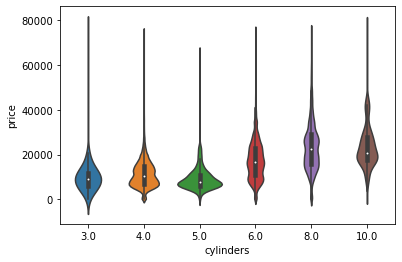

In [90]:
ax = sns.violinplot(x='cylinders', y='price', data=z2)

C:\Users\Tiki\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


price             1895116424
cylinders_3.0            173
cylinders_4.0          44296
cylinders_5.0            693
cylinders_6.0          42155
cylinders_8.0          27105
cylinders_10.0           329
dtype: int64

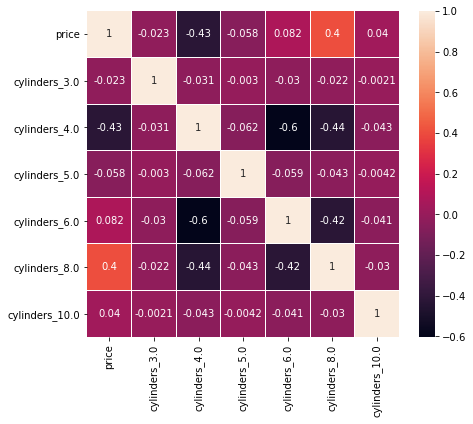

In [91]:
z_cyl=z2[['price', 'cylinders']]
z_cyl['cylinders'] = z_cyl['cylinders'].astype('category')
z_cyl = pd.get_dummies(z_cyl)
plt.figure(figsize=(7,6))
sns.heatmap(z_cyl.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')
z_cyl.sum()

In [92]:
z2['cylinders'] = z2['cylinders'].astype('category')
#drop for intercorrelation


## Feature manipulation: Longitude and Latitude

Longitude and latitude are interrcorelated. While states

from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
grid_params = {'n_neighbors': [5,10,15, 20,25],
               'weights': ['uniform', 'distance'],
               'metric':['euclidean','minkowski', 'manhattan']
              }
long = z2['long'].to_numpy()
lat = z2['lat'].to_numpy() 
gs = GridSearchCV(knn, grid_params, verbose=1, cv=3)
gs_results =gs.fit(long, lat)
gs_results.best_score_
gs_results.best_estimator

## Feature Selection: Dropping Continous Variables
### Eliminate variables due to intercorrelation

We check correlation between our features. We do not want highly correlated variables (aka correlation whose absolute value is of over 0.8 in our data). In our investigation we only find year which is highly correlated to age. We therefore eliminated year from our variables.

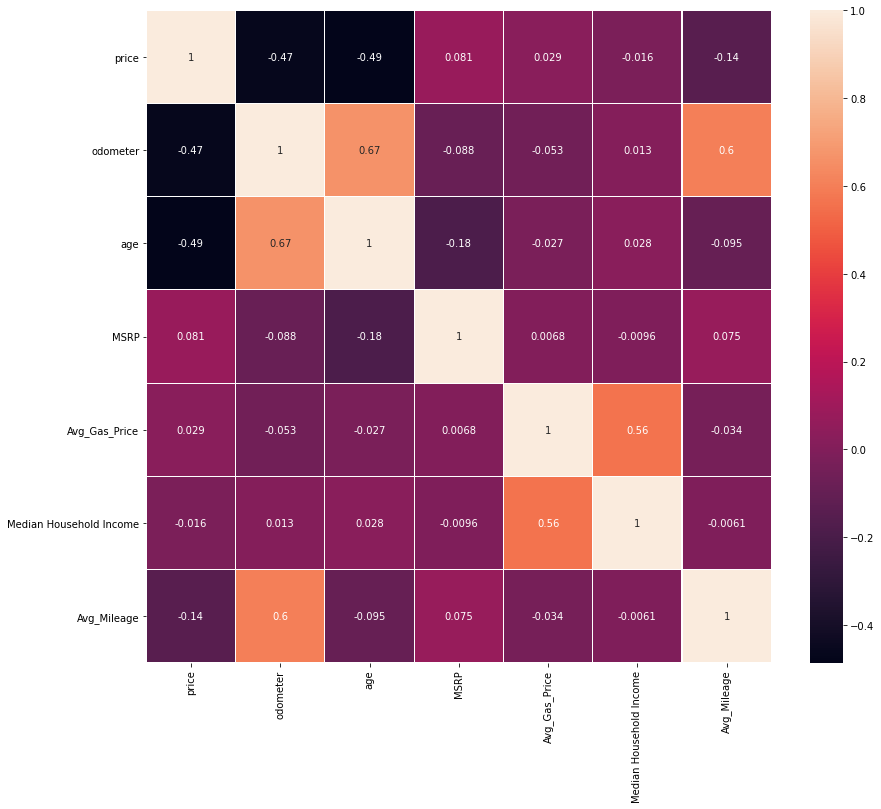

In [93]:
plt.figure(figsize=(14,12))
sns.heatmap(z2.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

We note that there are no variables whose absolute correlation is over 0.8

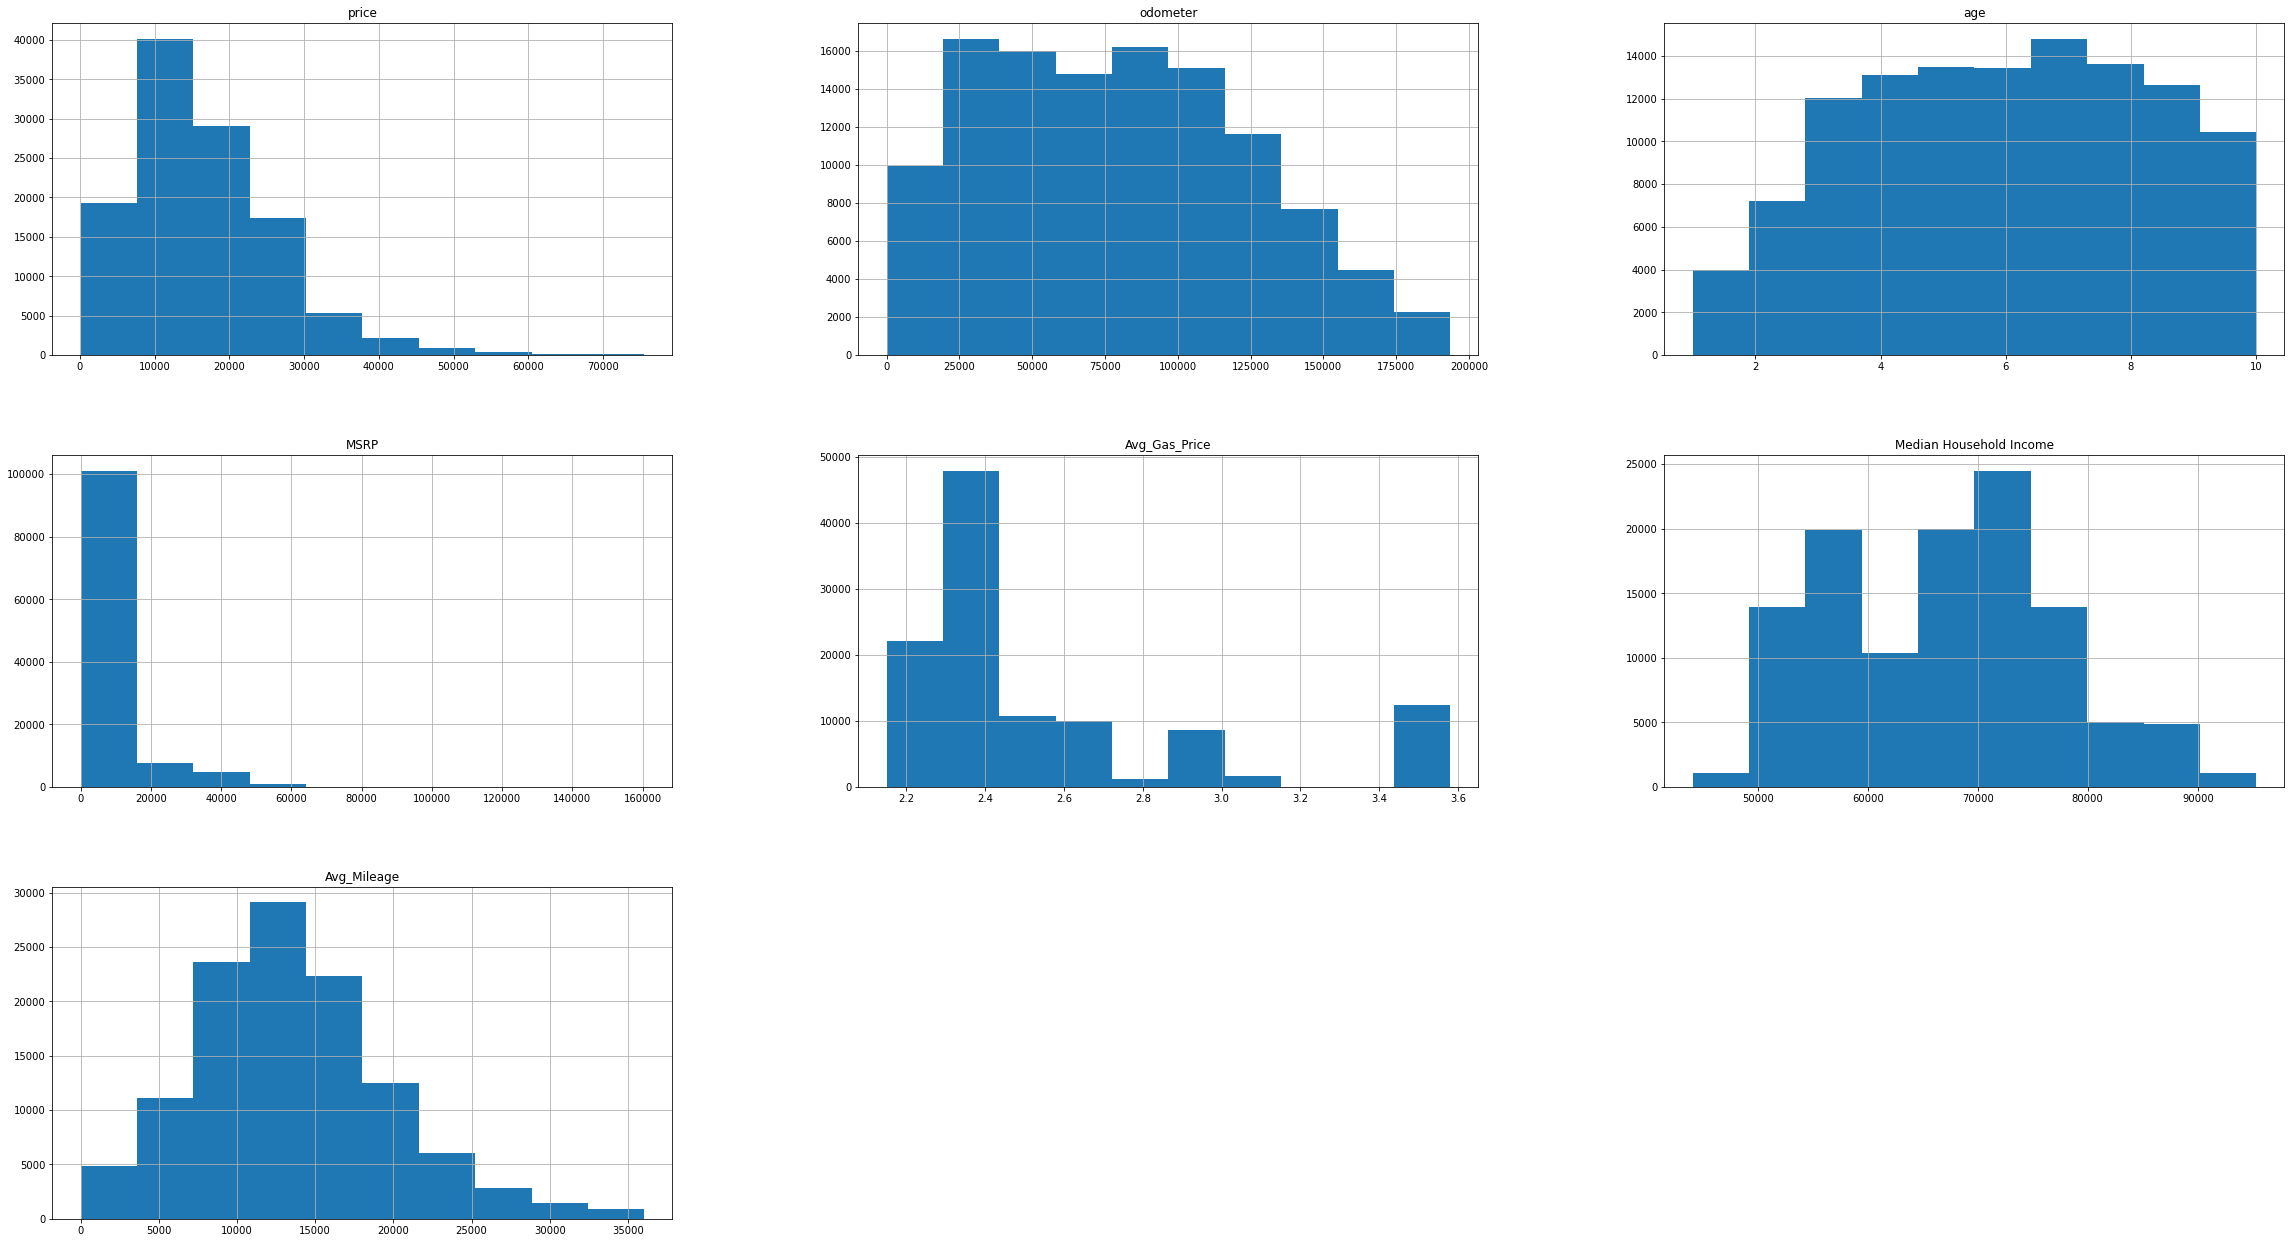

In [94]:

hist = z2.hist(figsize=(40,22))
#The data for price is and age are not a normal destribution so both normalize scaler is bad idea 

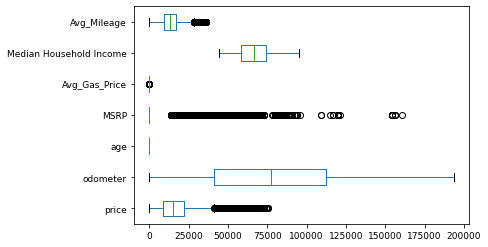

In [95]:
boxplot = z2.boxplot(grid=False, vert=False,fontsize=9)
#No large outliers as that was cleaned out already earlier will not use Robust Scaler

In [96]:
#save data

new_file = 'auto_data_cleaned.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
z2.to_csv(new_file_name_path, index=False)

## Pre Processing the Data

Befeore we can use the data to generate a model we need to make the data able to be understood by the model. In this case we scale the data and turn all our categorical variables into dummy variables. We then seperate the data into our training data and test data.


## Chosing Scaler Standardization

#### Standizing Data
* We have a few methods of standardization to choose from: Robust, Minmax, Normalize and Standardize
* We use Robust if we want to minimize impact of outliers
* We use Normalize if we think the distrubtion within a variable needs to be normalized and/or has a normal distribution
* We use Standardize when we think most of the variables have similar distribution and no/few dummy variables

#### Choosing Min Max Scaler
* The data for price is and age are not a normal destribution we eliminate normalize scaler
* No large outliers as that was cleaned out already earlier we eliminate  Robust Scaler
* As we have dummy variables we can eliminate standard scaler 
* That leaves us with Min Max scaler

## Create Dummy Variables

In [97]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_cleaned.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
z3 = pd.read_csv(file_name_path)
z3 = z3.reset_index()

C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto trimmed price.ipynb', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2_sqrt.ipynb', 'auto_clean_copy3 State vs Region.ipynb', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_deletion.png', 'figures', 'Figx_ModelComparison.png', 'Figx_ModelComparison_MPE.png', 'Figx_ModelComparison_Std.png', 'Figx_Model_Comparison_RMSLE.png', 'Figx_Model_Comparison_std.png', 'Scrap.ipynb']


In [98]:
#shrink data where we can
categorical_columns = z3.select_dtypes(exclude=['int64', 'float']).columns.tolist()
for col in categorical_columns:
    z3[col] = z3[col].astype('category')
    
z3['cylinders'] = z3['cylinders'].astype('category')
z3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114751 entries, 0 to 114750
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   index                    114751 non-null  int64   
 1   price                    114751 non-null  int64   
 2   manufacturer             114751 non-null  category
 3   condition                114751 non-null  category
 4   cylinders                114751 non-null  category
 5   fuel                     114751 non-null  category
 6   odometer                 114751 non-null  float64 
 7   transmission             114751 non-null  category
 8   drive                    114751 non-null  category
 9   size                     114751 non-null  category
 10  paint_color              114751 non-null  category
 11  state                    114751 non-null  category
 12  age                      114751 non-null  float64 
 13  MSRP                     114751 non-null  fl

In [99]:
#create dummy variables
Category_Cleaned = z3['Category_Cleaned']
auto_data_dummies= pd.get_dummies(z3) #changed from z2


In [100]:
new_file = 'auto_data_dummies.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data_dummies.to_csv(new_file_name_path, index=False)

In [101]:
df =auto_data_dummies.corr(method ='pearson')
df = df[((df > 0.7) | (df < -0.7)) & (df != 1)]
non_empty_cols = [col for col in df.columns if ~df[col].isnull().all()]
empty_cols = [col for col in df.columns if df[col].isnull().all()]

## Pre Processing Feature Selection: Dropping Dummy Variables
### Eliminate variables due to intercorrelation


1) Group Intercorrelation
When we have a categorical variables and convert them into dummies we can cannot have all the dummies in the group since  the last dummy variable will be a linear combination of the other dummies. So we eliminate one variable from the group.

2) Eliminate variables where absolute correlation is greater 0.8

['price', 'odometer', 'age', 'MSRP', 'Avg_Gas_Price', 'Median Household Income', 'Avg_Mileage', 'manufacturer_Acura', 'manufacturer_Alfa-Romeo']
['condition_fair', 'condition_like new', 'condition_new', 'cylinders_3.0', 'cylinders_4.0', 'cylinders_6.0', 'cylinders_8.0', 'cylinders_10.0', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other', 'transmission_automatic', 'transmission_manual', 'drive_4wd', 'drive_rwd', 'size_compact']


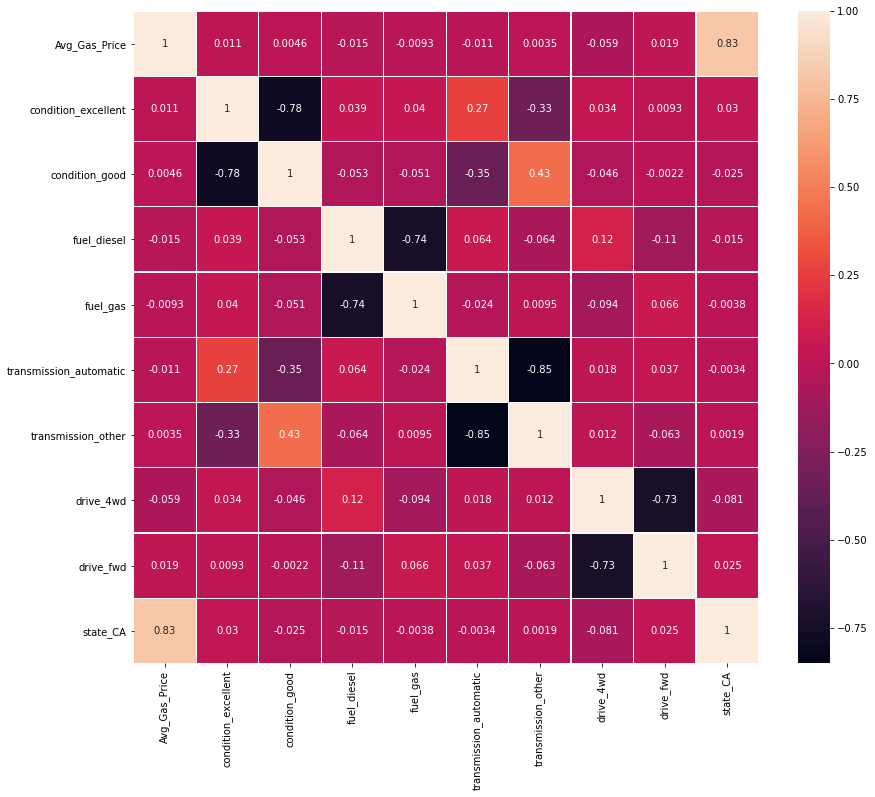

In [102]:
auto_data_dummies_small = auto_data_dummies.drop(columns= empty_cols)
plt.figure(figsize=(14,12))
sns.heatmap(auto_data_dummies_small.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

#Eliminate variables where absolute correlation is greater 0.8
auto_data_dummies2= auto_data_dummies.drop(columns= ['condition_good', 'fuel_diesel', 'transmission_other', 'drive_fwd', 'state_CA']) 

#eliminateto mass dummy intercorrelation
auto_data_dummies2= auto_data_dummies2.drop(columns= ['size_mid-size', 'paint_color_red', 'manufacturer_Infiniti', 'cylinders_5.0', 'index']) 

ac= auto_data_dummies2.columns.tolist()
print(ac[:9])
print(ac[43:60])

In [103]:
auto_data_dummies2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114751 entries, 0 to 114750
Columns: 136 entries, price to Category_Cleaned_Wagon
dtypes: float64(6), int64(1), uint8(129)
memory usage: 20.2 MB


## Seperate Data for Test and Trial

In [104]:
#seperate X and y from each other
X = auto_data_dummies2
print(type(X))
y = auto_data_dummies2['price']

X =X.drop(columns=['price'], axis=1)

#split train, trial and vals

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.25, random_state=42)


# Create val and train sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 3/11)

<class 'pandas.core.frame.DataFrame'>


## Use the MinMax Scaler on Data

In [105]:
#standardize numeric variables
from sklearn.preprocessing import MinMaxScaler

#create scaler
scaler = MinMaxScaler()

#Scale numeric data1
X_train_mm = scaler.fit_transform(X_train)
X_val_mm = scaler.transform(X_val)
X_test_mm = scaler.transform(X_test)

In [106]:
df_cl_list=X_train.columns.tolist()
df3 = pd.DataFrame(X_train_mm, columns = df_cl_list)
df3 = df3.iloc[:, : 7]
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62591 entries, 0 to 62590
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   odometer                 62591 non-null  float64
 1   age                      62591 non-null  float64
 2   MSRP                     62591 non-null  float64
 3   Avg_Gas_Price            62591 non-null  float64
 4   Median Household Income  62591 non-null  float64
 5   Avg_Mileage              62591 non-null  float64
 6   manufacturer_Acura       62591 non-null  float64
dtypes: float64(7)
memory usage: 3.3 MB


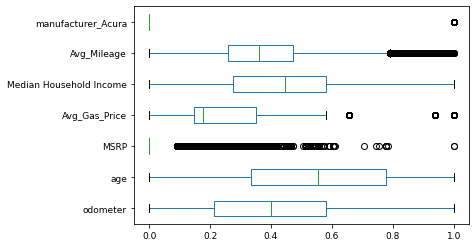

In [107]:
boxplot = df3.boxplot(grid=False, vert=False,fontsize=9)

In [108]:
from sklearn.linear_model import Ridge
#ridge = Ridge(solver='svd')
#ridge1 = Ridge(solver='svd')  
    

ridge = Ridge(solver='lsqr') #fastest solver for Ridge Regression
ridge1 = Ridge(solver='lsqr') #fastest solver for Ridge Regression 
    
    
#Instantiate and fit a ridge reg to the min_max scaled data
ridge_scaled = ridge.fit(X_train_mm, y_train)


# Instantiate and fit ridge reg classifier to the unscaled data
ridge_unscaled = ridge1.fit(X_train, y_train)


# Compute and print metrics
print('Accuracy with Min Max Scaling: {}'.format(ridge_scaled.score(X_val_mm, y_val)))
print('Accuracy without Scaling: {}'.format(ridge_unscaled.score(X_val, y_val)))


Accuracy with Min Max Scaling: 0.708532998397611
Accuracy without Scaling: 0.24595773387134623


## Testing Models

## Comparison of the models:

We tested 6 different regression models 
* Linear
* Linear Log
* Ridge
* Ridge with PCA
* Linear with PCA
* elasticnet with PCA

We Test with Two parameterrs
* Median Absolute Error: MAE
* Mean Percentage Error: MPE

Our dealer is using our prediction to decide if the asking price is lower than the predicted price he could get on Craig's list. The dealer is risk averse he does not want to take the deal if there is a high chance that the predicted price he is using is larger than the actual price. Therefore between two equally accurate models he would prefer if the  predictions under valued the car then over valued the car.

The Median Absolute Error (MAE) is useful for just getting an overall fit of the model.It is a quick and easy way to compare how well one model does versus the other. Further it is not effected by the number of parameters as say R squared. This will give us the close prediction that we want. The closer the MAE

The Median Percentage Error (MPE) tells us if our regression over estimates (positve MPE) or under estimates (negative MPE).  Between two similar models in accordance to our dealer's risk aversion we prefer a negative MPE. 

For More Information:
https://www.dataquest.io/blog/understanding-regression-error-metrics/


#### Base testing Creating MPE , MAE, and comparison charts

We are going to put some restraints on the prediction. We know that the minimum price of the car is 0. So when we take the regressions we will zero out and predictions greater than 0.

In [109]:
from sklearn.metrics import make_scorer, median_absolute_error, mean_absolute_error

#Create MAE loss function
def MedianAbsoluteError(real:np.ndarray, predicted:np.ndarray) -> np.float64:
    """
    The Mean (MAE) metric 
    :param real: The ground truth labels given in the dataset
    :param predicted: Our predictions
    :return: The Mean Absolute Error Score
    """
    predicted[predicted<0] = 0
    return median_absolute_error(real, predicted)

#Create MPE loss function
def MPE_func(real, predicted):
    """
    The Median (MAE) metric 
    :param real: The ground truth labels given in the dataset
    :param predicted: Our predictions
    :return: The Median Percentage Error Score
    """
    predicted[predicted<0] = 0
    return np.median((predicted- real)/real)

#Turn MAE and MPE into scorers
mae = make_scorer(MedianAbsoluteError, greater_is_better=False)
mpe = make_scorer(MPE_func, greater_is_better=False)

def quick_run(estimatorx, X_train, y_train, X_test, y_test, folds=5, name_g= 'default'):
    """
    Put in X and Y train and test values as well as the estimator
    ___
    Returns:  Y_ predictions and cross validated statistics
    """
 
    #fit estimate
    estimatorx.fit(X_train, y_train)
        
    # Predict using model:
    y_predict= estimatorx.predict(X_train)
    y_predict_test = estimatorx.predict(X_test)
    y_predict[y_predict<0] = 0 #The minimum price for a car is 0
    y_predict_test[y_predict_test<0] = 0 #The minimum price for a car is 0   
    
    from sklearn.model_selection import cross_val_score
    #Cross validate scores for rmsle
    #cv_scores_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=rmsle_score)
    #cv_scores_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=rmsle_score)
    
    cv_scores_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=mpe)
    cv_scores_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=mpe)
    
    #Cross validate scores for R2
    cv_mae_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=mae)
    cv_mae_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=mae)
    
    #get stats for cross validated scored mpe
    
    cv_scores_test_mean= cv_scores_test.mean()
    cv_scores_train_mean= cv_scores_train.mean()
    cv_scores_test_std= cv_scores_test.std()
    
    #get stats for cross validated scored mae
    #because in our scorer we used "greater"
    cv_mae_test_mean= -cv_mae_test.mean()
    cv_mae_train_mean= -cv_mae_train.mean()
    cv_mae_test_std= cv_mae_test.std()
    if name_g == 'default':
        name_reg = str(estimatorx)
    else:
        name_reg = name_g
    c= [name_reg,cv_mae_train_mean,  cv_mae_test_mean, cv_mae_test_std, cv_scores_train_mean, cv_scores_test_mean, cv_scores_test_std]
    

    print('Cross Validated Scores for regression equation: {} '.format(name_reg))
    print('Median Absolute Error: ')
    print ('Mean train score: ${:.0f} '.format(cv_mae_train_mean))
    print ('Mean test score: ${:.0f} '.format(cv_mae_test_mean))
    print ('Standard Deviation test score: ${:.0f} '.format(cv_mae_test_std))
    print('')
    print('MPE: ')
    print ('Mean train score: {:.5f} '.format(cv_scores_train_mean))
    print ('Mean test score: {:.5f} '.format(cv_scores_test_mean))
    print ('Standard Deviation test score: {:.5f} '.format(cv_scores_test_std))
    print('')
    diff = y_test -y_predict_test

    
    fig, axs = plt.subplots(2, 2, figsize=(14,5), sharey=True) #Create two sub plots sharing x and y axis
    fig.suptitle('Error in Price Prediction for {} Regression'.format(name_reg), fontsize=16, y=1 , x= 0.45)
    
    #plt scatter
    from scipy.stats import kde
    
    ax1 = plt.subplot(121)
    #sc= plt.scatter(y_test, diff, s= 1, c= cylinders_z)
    sc= plt.scatter(y_test, diff, s= 2, alpha=0.2)
    y_test_lim_up = y_test.quantile(.99)
    y_test_lim_down = y_test.quantile(.01)
    plt.xlim(y_test_lim_down, y_test_lim_up)
    plt.title('Actual Price vs Error')
    plt.ylabel('Error in $ ')
    plt.xlabel('Actual Price in $')
    plt.box(on=None)
    #cbar= plt.colorbar(sc)
    #cbar.set_label('# of cylinders', rotation=90)

    
    ax2 = plt.subplot(122)
    diff.hist(bins = 50, orientation='horizontal')
    plt.title('Histogram of Error')
    plt.ylabel('Error in $ ')
    plt.xlabel('Frequency')
    plt.box(on=None)
    plt.grid(color='white')
    plt.show()  
    

   
    return y_predict_test, c



#### Base testing 1 - Linear

Cross Validated Scores for regression equation: Linear 
Median Absolute Error: 
Mean train score: $2402 
Mean test score: $2368 
Standard Deviation test score: $33 

MPE: 
Mean train score: -0.00667 
Mean test score: -0.00472 
Standard Deviation test score: 0.00584 



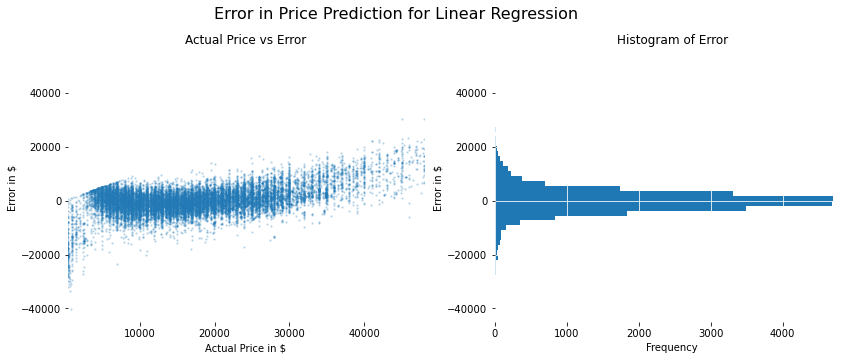

In [110]:
# Apply Linear model to training data:
linear = LinearRegression() 
y_predict_test_linear, c_linear = quick_run(linear, X_train_mm, y_train, X_val_mm, y_val, name_g= 'Linear')

#### Base testing 2 - Linear_Log

Cross Validated Scores for regression equation: Linear Log 
Median Absolute Error: 
Mean train score: $0 
Mean test score: $0 
Standard Deviation test score: $0 

MPE: 
Mean train score: 0.00607 
Mean test score: 0.00596 
Standard Deviation test score: 0.00027 



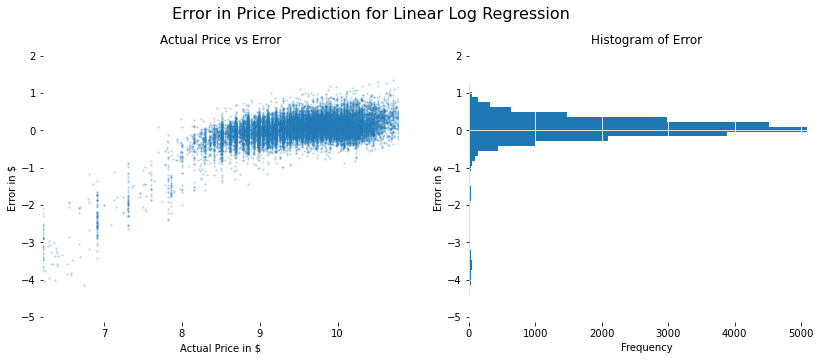

In [111]:
# Apply Linear Log model to training data:
linlog = LinearRegression() #previous optimization different study
y_train_lg = np.log(y_train)
y_val_lg = np.log(y_val)
y_predict_test_linlog, c_linlog = quick_run(linlog, X_train_mm, y_train_lg, X_val_mm, y_val_lg, name_g ='Linear Log')


#### Base testing 3 - Ridge

Cross Validated Scores for regression equation: Ridge 
Median Absolute Error: 
Mean train score: $2403 
Mean test score: $2366 
Standard Deviation test score: $34 

MPE: 
Mean train score: -0.00653 
Mean test score: -0.00494 
Standard Deviation test score: 0.00597 



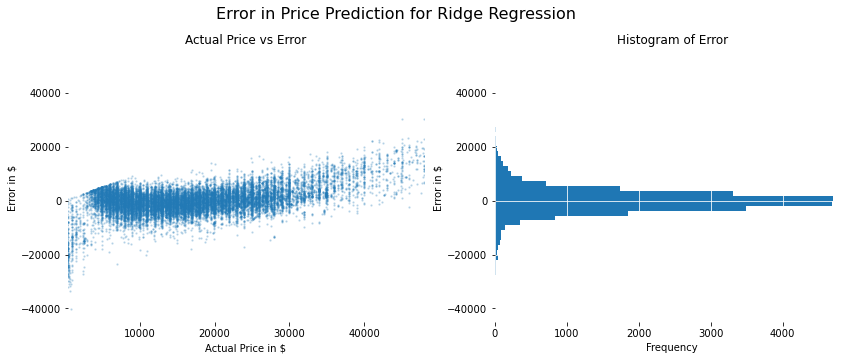

In [112]:
# Apply Ridge model to training data:
ridge_s = Ridge(solver=  'svd') #We specify solver because otherwise the program decides whichever solver it deems best

y_predict_test_ridge, c_ridge = quick_run(ridge_s, X_train_mm, y_train, X_val_mm, y_val, name_g= 'Ridge')

#2384, 2443, m


#### Base testing 4 - Elasticnet

Cross Validated Scores for regression equation: ElasticNet 
Median Absolute Error: 
Mean train score: $4444 
Mean test score: $4476 
Standard Deviation test score: $32 

MPE: 
Mean train score: -0.07776 
Mean test score: -0.07986 
Standard Deviation test score: 0.00457 



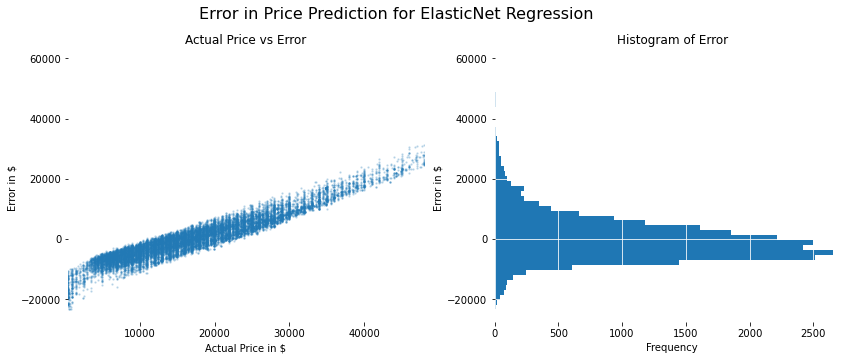

In [113]:
elastic = ElasticNet( selection= 'random'  ) #random was selected as the selector since it is faster
y_predict_test_elastic, c_elastic = quick_run(elastic, X_train_mm, y_train, X_val_mm, y_val,  name_g= 'ElasticNet')


#### Base testing 5 - Decision Tree Regression

Cross Validated Scores for regression equation: Decision Tree 
Median Absolute Error: 
Mean train score: $3111 
Mean test score: $2996 
Standard Deviation test score: $65 

MPE: 
Mean train score: -0.03547 
Mean test score: -0.03232 
Standard Deviation test score: 0.00381 



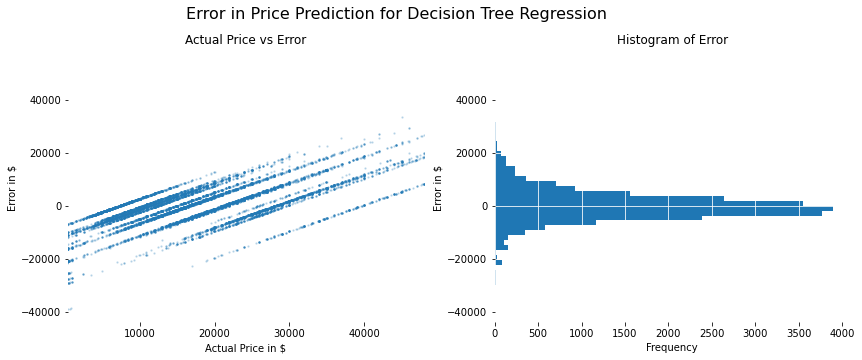

In [114]:
from sklearn.tree import DecisionTreeRegressor
dt_1 = DecisionTreeRegressor(max_depth=4)
y_predict_test_dt, c_dt = quick_run(dt_1, X_train_mm, y_train, X_val_mm, y_val,  name_g= 'Decision Tree')


#### Base Testing 6- Extra Tree Regression

Cross Validated Scores for regression equation: Extra Tree 
Median Absolute Error: 
Mean train score: $3331 
Mean test score: $3163 
Standard Deviation test score: $108 

MPE: 
Mean train score: -0.03316 
Mean test score: -0.03131 
Standard Deviation test score: 0.00251 



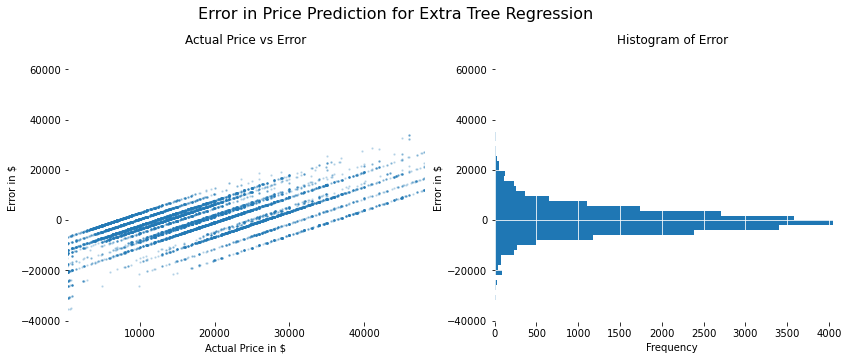

In [115]:
from sklearn.tree import ExtraTreeRegressor
ext_1 = ExtraTreeRegressor(max_depth=4)
y_predict_test_ext, c_ext = quick_run(ext_1, X_train_mm, y_train, X_val_mm, y_val,  name_g= 'Extra Tree')


#### Base Testing 7- Gamma Regression

Cross Validated Scores for regression equation: Gamma 
Median Absolute Error: 
Mean train score: $2869 
Mean test score: $2847 
Standard Deviation test score: $70 

MPE: 
Mean train score: -0.00701 
Mean test score: -0.00879 
Standard Deviation test score: 0.00111 



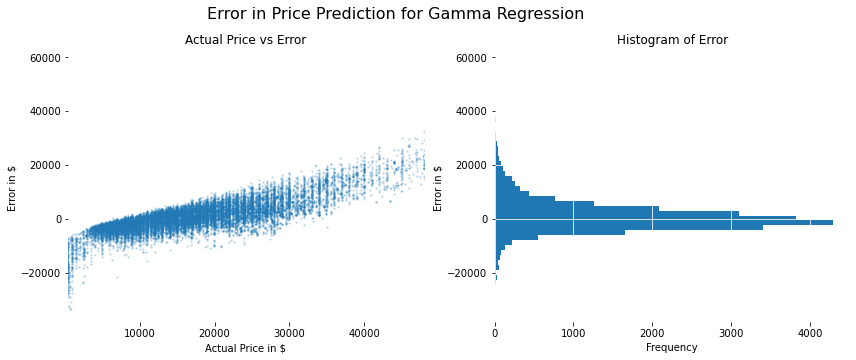

In [116]:
from sklearn.linear_model import GammaRegressor

gr = GammaRegressor(alpha=0.1) 
y_predict_test_gr, c_gr = quick_run(gr, X_train_mm, y_train, X_val_mm, y_val,  name_g= 'Gamma')


#### Base testing 8 - Linear PCA

Cross Validated Scores for regression equation: PCA Linear 
Median Absolute Error: 
Mean train score: $4200 
Mean test score: $4218 
Standard Deviation test score: $54 

MPE: 
Mean train score: -0.04231 
Mean test score: -0.04642 
Standard Deviation test score: 0.00296 



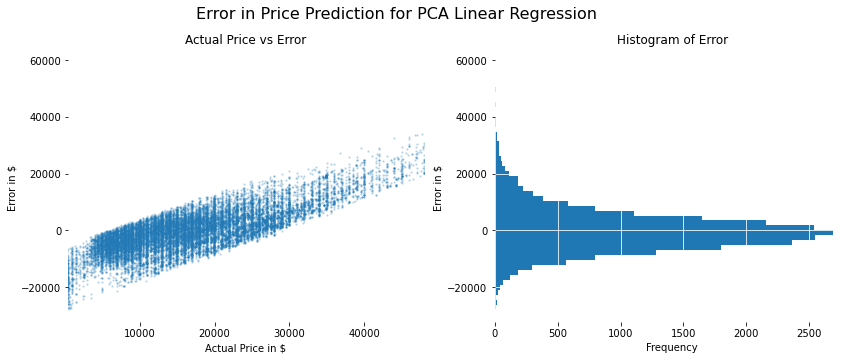

In [117]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=3) #from previous opt
# set the tolerance to a large value to make the example faster
linearz = LinearRegression()
pc_lin = Pipeline(steps=[('pca', pca), ('linear', linearz)])

y_predict_test_pca_lin, c_pca_lin = quick_run(pc_lin, X_train_mm, y_train, X_val_mm, y_val, name_g= 'PCA Linear')


#### Base testing 9 - Ridge PCA

Cross Validated Scores for regression equation: PCA Ridge 
Median Absolute Error: 
Mean train score: $4200 
Mean test score: $4217 
Standard Deviation test score: $54 

MPE: 
Mean train score: -0.04231 
Mean test score: -0.04642 
Standard Deviation test score: 0.00297 



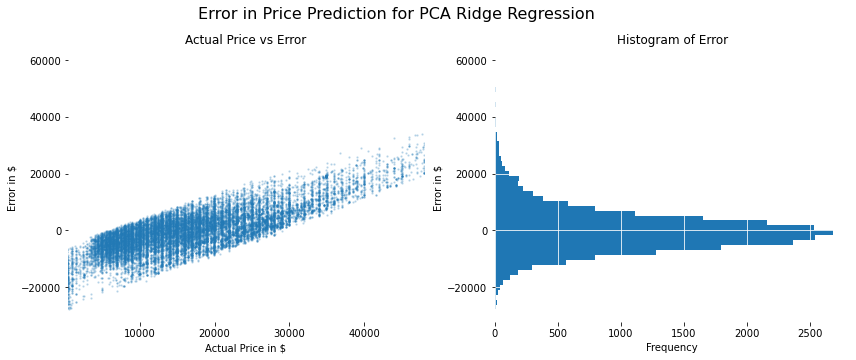

In [118]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=3) #from previous opt
# set the tolerance to a large value to make the example faster
ridge_p =  Ridge(solver='lsqr') #fastest solver for ridge
pc_ridge = Pipeline(steps=[('pca', pca), ('ridge', ridge_p)])

y_predict_test_pca_ridge, c_pca_ridge = quick_run(pc_ridge, X_train_mm, y_train, X_val_mm, y_val, name_g= 'PCA Ridge')



#### Base testing 10 - Elasticnet PCA

Cross Validated Scores for regression equation: PCA Elastic 
Median Absolute Error: 
Mean train score: $4200 
Mean test score: $4217 
Standard Deviation test score: $54 

MPE: 
Mean train score: -0.04232 
Mean test score: -0.04645 
Standard Deviation test score: 0.00295 



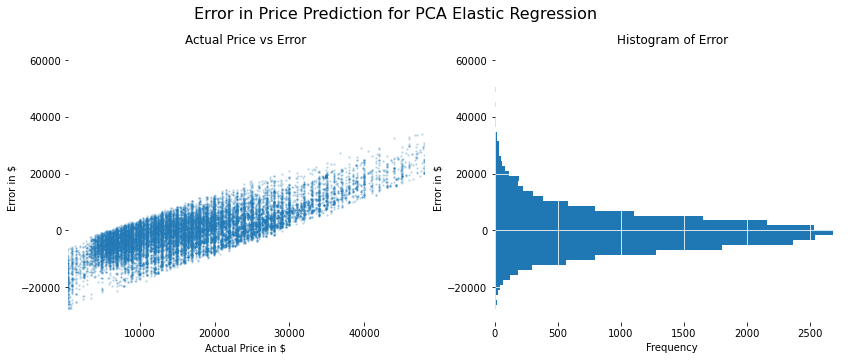

In [119]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=3) #from previous opt
# set the tolerance to a large value to make the example faster
elastic_p =  ElasticNet( selection= 'random' )  #fastest selection for elastic

pc_elastic = Pipeline(steps=[('pca', pca), ('elastic_p', elastic_p)])

y_predict_test_pca_elastic, c_pca_elastic = quick_run(pc_ridge, X_train_mm, y_train, X_val_mm, y_val, name_g= 'PCA Elastic')


### Comparing Models

As we look at the 6 models we find a two trends:
* All of these models over estimate versus under estimate (MPE is negative).
* Models with the same PCA have very similar MAE results, usually which are worse than their non PCA counterparts.

Of the Non PCA regressions we can start eliminating:
* Linear Regression- Low MAE Train and High MAE Test : Which suggests over fitting when we use pure linear regression)
* ElasticNet- High MAE Test and Train score so we eliminate it
* Ridge Regression- Best MAE Train and Test scores (and lets us have multicollinearity

#### Comparing Models table

In [120]:
score_columns= ['Algorithm', 'MAE Train', 'MAE Test',  'MAE Test std', 'MPE Train', 'MPE Test',  'MPE Test std']
c_data =[c_linear, c_ridge, c_elastic, c_dt, c_ext, c_gr, c_pca_lin, c_pca_ridge, c_pca_elastic]
convert_dict = {'MAE Train': int, 'MAE Test': int} 
score_tab = pd.DataFrame(c_data, columns= score_columns )
score_tab = score_tab.astype(convert_dict) 
pd.options.display.float_format = '{:.3f}'.format
score_tab.sort_values('MAE Test')



,Algorithm,MAE Train,MAE Test,MAE Test std,MPE Train,MPE Test,MPE Test std
1,Ridge,2403,2366,33.645,-0.007,-0.005,0.006
0,Linear,2402,2367,33.175,-0.007,-0.005,0.006
5,Gamma,2869,2846,69.501,-0.007,-0.009,0.001
3,Decision Tree,3111,2995,65.326,-0.035,-0.032,0.004
4,Extra Tree,3330,3163,107.659,-0.033,-0.031,0.003
6,PCA Linear,4199,4217,53.657,-0.042,-0.046,0.003
7,PCA Ridge,4199,4217,53.895,-0.042,-0.046,0.003
8,PCA Elastic,4200,4217,53.658,-0.042,-0.046,0.003
2,ElasticNet,4443,4475,32.379,-0.078,-0.080,0.005


#### Comparing Models Graph

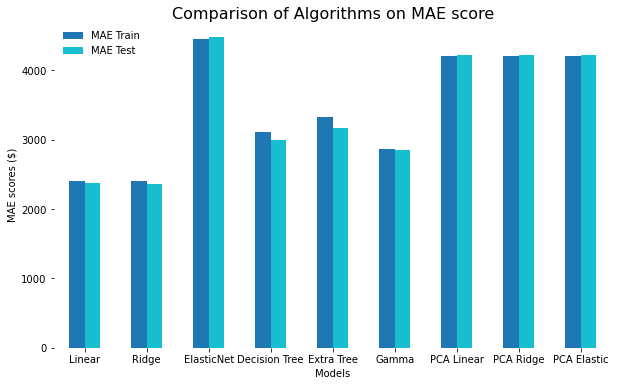

In [121]:
from matplotlib import cm
score_tab_MAE= score_tab[['Algorithm','MAE Train', 'MAE Test']].set_index('Algorithm')
cmap = cm.get_cmap('tab10') 

ax=score_tab_MAE.plot.bar(rot=0, figsize=(10,6), cmap=cmap )

plt.title('Comparison of Algorithms on MAE score', fontsize=16, pad=0.1)
plt.legend(frameon= False)
plt.box(on=None)
plt.xlabel('Models',fontsize=10)
plt.ylabel ('MAE scores ($)',fontsize=10)
plt.savefig("Figx_ModelComparison.png")


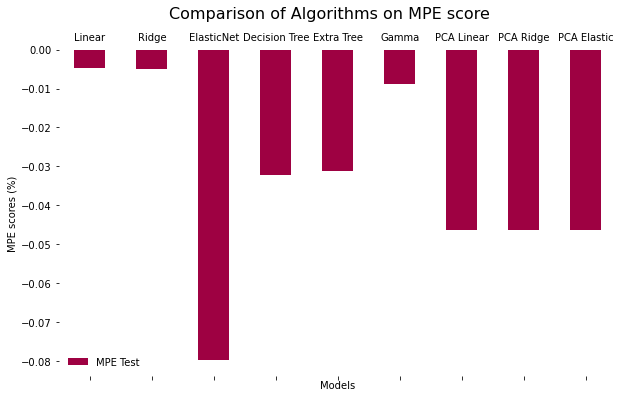

In [122]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

score_tab_MPE= score_tab[['Algorithm','MPE Test']].set_index('Algorithm')



ax=score_tab_MPE.plot.bar(rot=0, figsize=(10,6), cmap=cmap )
ax.tick_params(labelbottom=False,labeltop=True)
plt.suptitle('Comparison of Algorithms on MPE score', fontsize=16,)

plt.xlabel('Models',fontsize=10)
plt.ylabel ('MPE scores (%)',fontsize=10)
plt.legend(frameon= False)
plt.box(on=None)
plt.savefig("Figx_ModelComparison_MPE.png")


### Optimizing Ridge Regression

Now that we know that Ridge Regression (with and without optimized PCA) looks like the best model we use a grid search to find the best parameters

### Applying Grid search CV for hyperparameter Tuning:

#### Hyperparameter Tuning: Ridge Regression

In [123]:
# Testing different Ridge Regressions
params_Ridge = {'alpha': [10, 1, 0.1, 0.01, 0.001], 'solver': ['svd', 'lsqr', 'cholesky'], 'fit_intercept': [True, False]}
ridge_reg = Ridge()
Ridge_GS = GridSearchCV(ridge_reg, param_grid=params_Ridge, cv=5, scoring= mae)
Ridge_GS.fit(X_train_mm, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [10, 1, 0.1, 0.01, 0.001],
                         'fit_intercept': [True, False],
                         'solver': ['svd', 'lsqr', 'cholesky']},
             scoring=make_scorer(MedianAbsoluteError, greater_is_better=False))

Using the best parameters from the grid search we create the best ridge model

In [124]:
print('For hyper parameter tuned Ridge Regression')
print('Best Score: {}'.format(-Ridge_GS.best_score_))
print('Best estimator: {}'.format(Ridge_GS.best_estimator_))
print('Best parameters: {}'.format(Ridge_GS.best_params_))



For hyper parameter tuned Ridge Regression
Best Score: 2402.454680971858
Best estimator: Ridge(alpha=10, solver='cholesky')
Best parameters: {'alpha': 10, 'fit_intercept': True, 'solver': 'cholesky'}


Cross Validated Scores for regression equation: Ridge(alpha=10, solver='cholesky') 
Median Absolute Error: 
Mean train score: $2402 
Mean test score: $2367 
Standard Deviation test score: $33 

MPE: 
Mean train score: -0.00722 
Mean test score: -0.00620 
Standard Deviation test score: 0.00607 



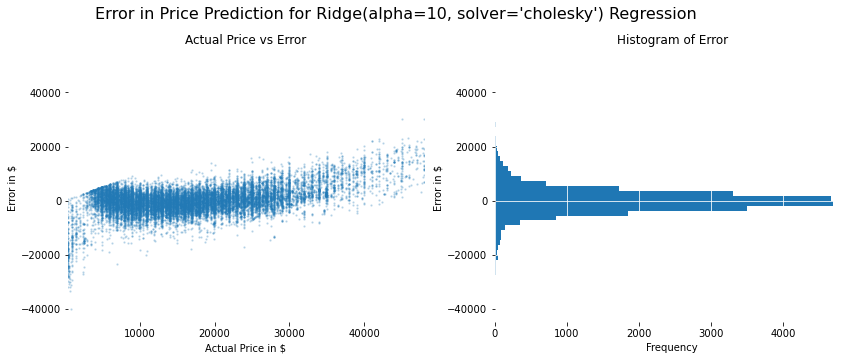

In [125]:
Ridge_opt = Ridge(**Ridge_GS.best_params_)
y_predict_test_ridge_opt, c_ridge_opt = quick_run(Ridge_opt, X_train_mm, y_train, X_val_mm, y_val)



### Looking at the error for Optimized Ridge Regression

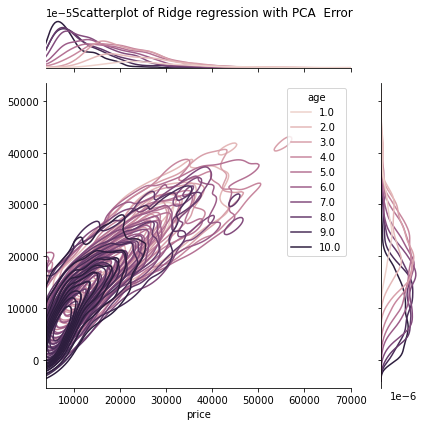

In [126]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral')
age = X_val['age']

p= sns.jointplot(x=y_val, y=y_predict_test_ridge_opt, kind="kde", xlim= [4000, 70000], hue=age)
p.fig.suptitle("Scatterplot of Ridge regression with PCA  Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

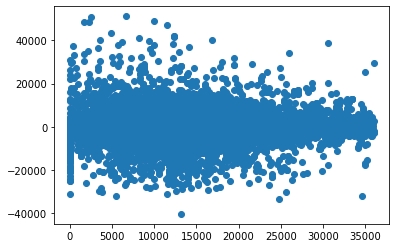

In [127]:
error_opt= y_val -y_predict_test_ridge_opt 
age = X_val['age']
odometer = X_val['odometer']
avg_mile = X_val['Avg_Mileage']
#plt.scatter(y_val, error_opt, c=odometer)
plt.scatter(avg_mile, error_opt)
#ax = sns.violinplot(x=X_val['age'], y=error_opt)


### Calculating Coefficents and it's importance

In [128]:

#Table and features

#coeficent value and name
feature_names = X_train.columns

coefs = pd.DataFrame(
    Ridge_opt.coef_,
    columns=['Coefficients'], index=feature_names
)


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    Ridge_opt, X_train_mm, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5), scoring= mae,
    return_estimator=True
)
coefs2 = pd.DataFrame(
    [est.coef_  for est in cv_model['estimator']],
    columns=feature_names
)

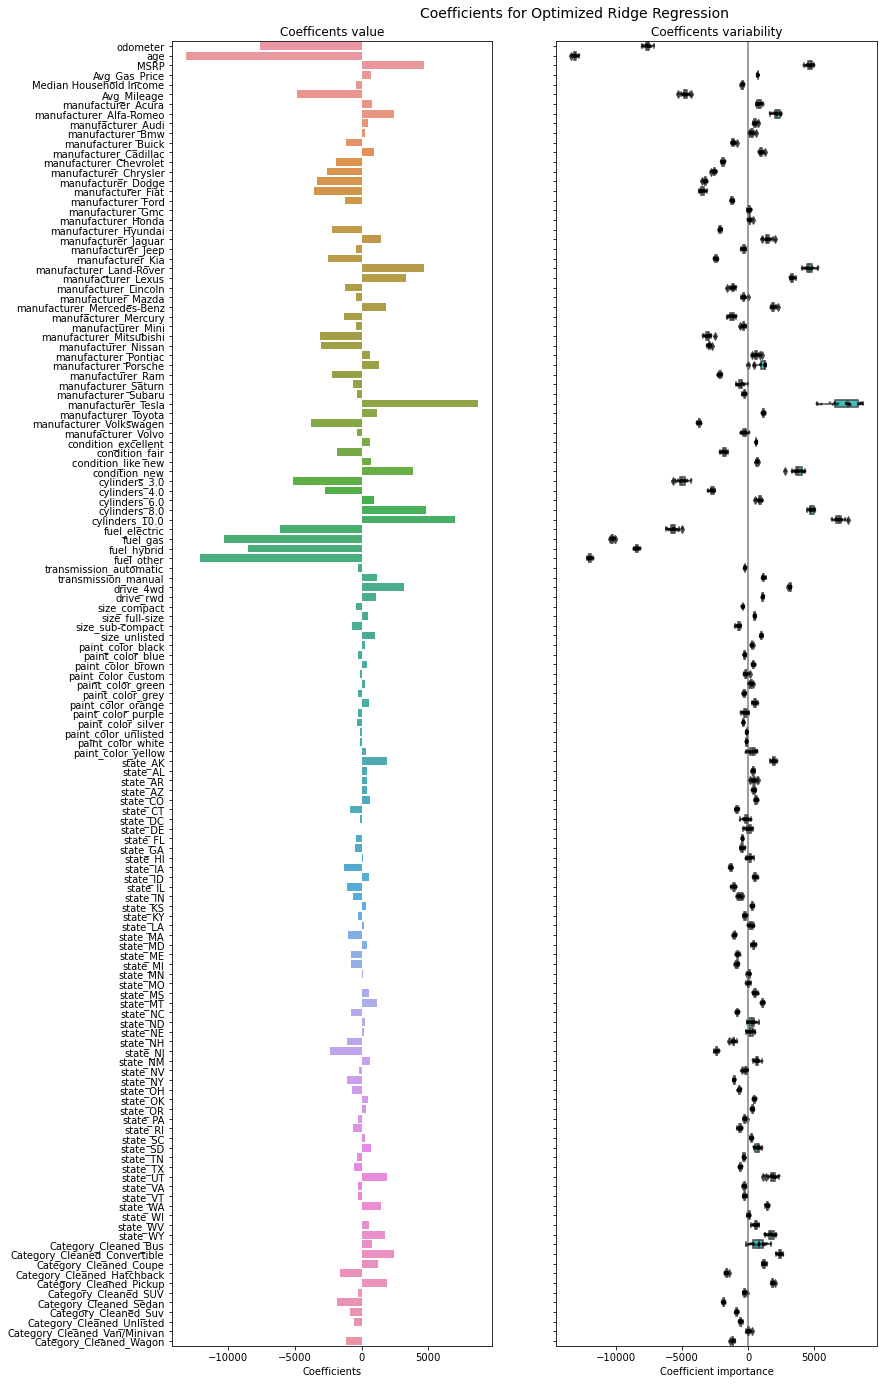

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(14, 24), sharey=True, sharex=True)
fig.suptitle('Coefficients for Optimized Ridge Regression', fontsize=14, y=0.9, x= 0.6)
ax = plt.subplot(121)
sns.barplot(x='Coefficients', y=feature_names, data=coefs)
plt.title("Coefficents value")

plt.subplot(122)
#graphing coefficent and importance
#sns.swarmplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.stripplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=coefs2, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title("Coefficents variability")
plt.xlabel('Coefficient importance')

plt.subplots_adjust(left=.2)

for ax in fig.get_axes():
    ax.label_outer()
#fig.title('Ridge model no PCA Coefficents')

### Notes on Coeficients
From the above we can see that paint colors have a small but likely non 0 value. Fuel, cylinder and manufacturer ended up having a larger signigant value.

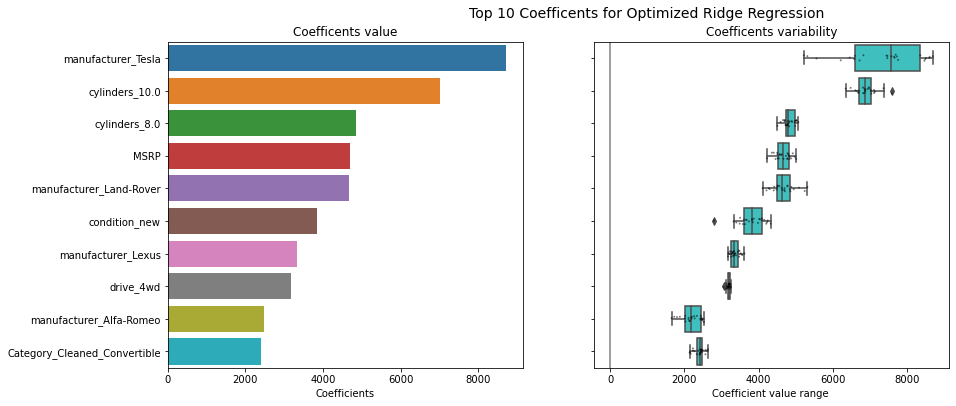

In [130]:
#coefs['Feature Names'] = coefs.index
#coefs_10 = 
feature_names_10 = coefs.sort_values(by= ['Coefficients'], ascending= False).head(10).index.tolist()
coefs_f10 = coefs.sort_values(by= ['Coefficients'], ascending= False).head(10)
coefs2_f10 = coefs2[feature_names_10]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True) #Create two sub plots sharing x and y axis
fig.suptitle('Top 10 Coefficents for Optimized Ridge Regression', fontsize=14, y=0.96, x= 0.6)

#First subplot - Barchart of features and their possible coefficent using cross fold
ax = plt.subplot(121)
sns.barplot(x='Coefficients', y=feature_names_10, data=coefs_f10)
plt.title("Coefficents value")

#Second subplot- boxplot and stripplot of 
plt.subplot(122)
sns.stripplot(data=coefs2_f10, orient='h', color='k', alpha=0.5, size=2)
sns.boxplot(data=coefs2_f10, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title("Coefficents variability")
plt.xlabel('Coefficient value range ')

#plt.subplots_adjust(left=.3)
for ax in fig.get_axes():
    ax.label_outer()
#fig.title('Ridge model no PCA Coefficents')

### Ridge with Feature selector addition

In [131]:
### Ridge feature selector
from sklearn.feature_selection import SelectKBest,f_regression
#we are going to use the best parameters (with the exception of alpha) from the previous search 
#and we are going to see if we optimize PCA if we can impove the regresion

ridge_ft = Ridge(**Ridge_GS.best_params_)
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
selector = SelectKBest(f_regression)
# set the tolerance to a large value to make the example faster
#ridge = Ridge(solver='lsqr')
pipe_F = Pipeline(steps=[('selector', selector), ('ridge', ridge_ft)])

search_F = GridSearchCV(
    estimator = pipe_F,
    param_grid = {'selector__k':[10,20,30, 40,60,80,100, 120, 125]},
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1
)
search_F.fit(X_train_mm, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_se

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector',
                                        SelectKBest(score_func=<function f_regression at 0x000000F04380EA68>)),
                                       ('ridge',
                                        Ridge(alpha=10, solver='cholesky'))]),
             param_grid={'selector__k': [10, 20, 30, 40, 60, 80, 100, 120,
                                         125]},
             scoring='neg_mean_squared_error', verbose=1)

In [132]:
print('For Min Max scaled data using chained PCA and Ridge  Regression')
print('Best Score: {}'.format(search_F.best_score_))
print('Best estimator: {}'.format(search_F.best_estimator_))
print('Best parameters: {}'.format(search_F.best_params_))

For Min Max scaled data using chained PCA and Ridge  Regression
Best Score: -27044611.92799591
Best estimator: Pipeline(steps=[('selector',
                 SelectKBest(k=125,
                             score_func=<function f_regression at 0x000000F04380EA68>)),
                ('ridge', Ridge(alpha=10, solver='cholesky'))])
Best parameters: {'selector__k': 125}


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered i

Cross Validated Scores for regression equation: #of Features 125, alpha = 10 and solver cholesky Ridge 
Median Absolute Error: 
Mean train score: $2402 
Mean test score: $2364 
Standard Deviation test score: $31 

MPE: 
Mean train score: -0.00717 
Mean test score: -0.00597 
Standard Deviation test score: 0.00641 



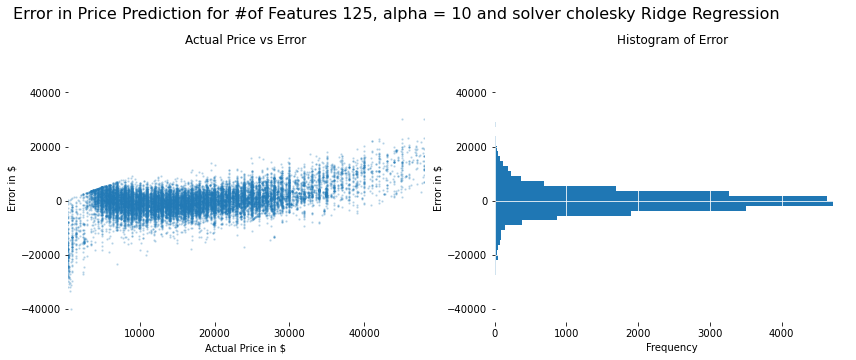

In [133]:
search_F.best_estimator_
f1= search_F.best_params_['selector__k']
f2 = Ridge_GS.best_params_['alpha']
f3 = Ridge_GS.best_params_['solver']
plt_title_ft= '#of Features {}, alpha = {} and solver {} Ridge'.format(f1, f2, f3)

pipe_f = search_F.best_estimator_
y_predict_test_rft, c_rft = quick_run(pipe_f, X_train_mm, y_train, X_val_mm, y_val, name_g= plt_title_ft)

### Ridge with Feature elimination

Optimal number of features : 129


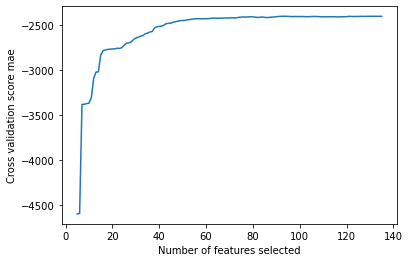

In [134]:

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# Build a classification task using 3 informative features
# Create the RFE object and compute a cross-validated score.
ridge_em = Ridge(**Ridge_GS.best_params_)


# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 5  # Minimum number of features to consider
rfecv = RFECV(estimator=ridge_em, step=1, cv=5,
              scoring=mae,
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train_mm, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score mae")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

Cross Validated Scores for regression equation: #of Features 129, alpha = 10 and solver cholesky Ridge 
Median Absolute Error: 
Mean train score: $2402 
Mean test score: $2367 
Standard Deviation test score: $33 

MPE: 
Mean train score: -0.00723 
Mean test score: -0.00613 
Standard Deviation test score: 0.00598 



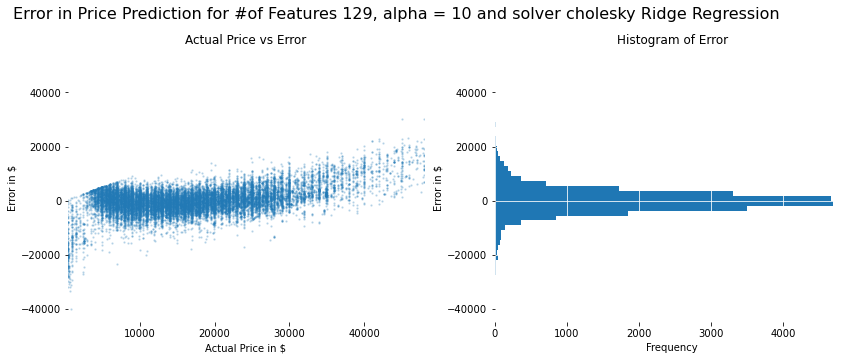

In [135]:
f1z= rfecv.n_features_
f2 = Ridge_GS.best_params_['alpha']
f3 = Ridge_GS.best_params_['solver']
plt_title_ftz= '#of Features {}, alpha = {} and solver {} Ridge'.format(f1z, f2, f3)

from sklearn.feature_selection import RFE

estimator_ftz =  Ridge(**Ridge_GS.best_params_)
rfe = RFE(estimator_ftz, n_features_to_select=rfecv.n_features_)


selector_rfe = RFE(f_regression,n_features_to_select=rfecv.n_features_)
# set the tolerance to a large value to make the example faster
#ridge = Ridge(solver='lsqr')
pipe_rfe = Pipeline(steps=[('selector', selector_rfe), ('ridge', ridge_ft)])

rfe= rfe.fit(X_train_mm, y_train)

y_predict_test_relim, c_ridge_elim = quick_run(rfe, X_train_mm, y_train, X_val_mm, y_val, 
                                                name_g= plt_title_ftz)



In [136]:
feature_names = X_train.columns
for i in range(X_train_mm.shape[1]):
    print('Column: {}, Selected {}, Rank: {}'.format(feature_names[i], rfe.support_[i], rfe.ranking_[i]))




Column: odometer, Selected True, Rank: 1
Column: age, Selected True, Rank: 1
Column: MSRP, Selected True, Rank: 1
Column: Avg_Gas_Price, Selected True, Rank: 1
Column: Median Household Income, Selected True, Rank: 1
Column: Avg_Mileage, Selected True, Rank: 1
Column: manufacturer_Acura, Selected True, Rank: 1
Column: manufacturer_Alfa-Romeo, Selected True, Rank: 1
Column: manufacturer_Audi, Selected True, Rank: 1
Column: manufacturer_Bmw, Selected True, Rank: 1
Column: manufacturer_Buick, Selected True, Rank: 1
Column: manufacturer_Cadillac, Selected True, Rank: 1
Column: manufacturer_Chevrolet, Selected True, Rank: 1
Column: manufacturer_Chrysler, Selected True, Rank: 1
Column: manufacturer_Dodge, Selected True, Rank: 1
Column: manufacturer_Fiat, Selected True, Rank: 1
Column: manufacturer_Ford, Selected True, Rank: 1
Column: manufacturer_Gmc, Selected False, Rank: 5
Column: manufacturer_Honda, Selected False, Rank: 4
Column: manufacturer_Hyundai, Selected True, Rank: 1
Column: manufa

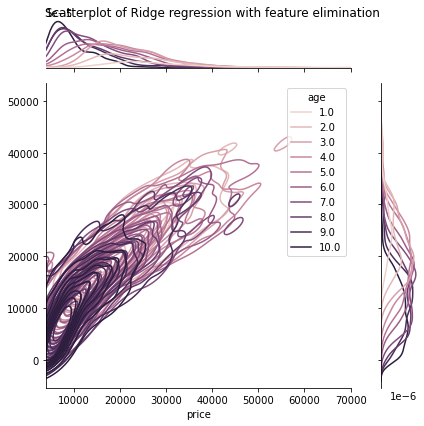

In [137]:
age = X_val['age']
from matplotlib import cm
cmap = cm.get_cmap('viridis')

p= sns.jointplot(x=y_val, y=y_predict_test_relim, kind="kde", xlim= [4000, 70000], hue= age )

p.fig.suptitle("Scatterplot of Ridge regression with feature elimination")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


### Ridge with PCA

In [138]:
### Ridge PCA chained

#we are going to use the best parameters (with the exception of alpha) from the previous search 
#and we are going to see if we optimize PCA if we can impove the regresion

ridge_dg = Ridge(**Ridge_GS.best_params_)
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
#ridge = Ridge(solver='lsqr')
pipe = Pipeline(steps=[('pca', pca), ('ridge', ridge_dg)])
   
param_grid = {
    'pca__n_components':  list(range(1,15)) ,
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring= mae)
search.fit(X_train_mm, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('ridge',
                                        Ridge(alpha=10, solver='cholesky'))]),
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14]},
             scoring=make_scorer(MedianAbsoluteError, greater_is_better=False))

In [139]:
print('For Min Max scaled data using chained PCA and Ridge  Regression')
print('Best Score: {}'.format(search.best_score_))
print('Best estimator: {}'.format(search.best_estimator_))
print('Best parameters: {}'.format(search.best_params_))

For Min Max scaled data using chained PCA and Ridge  Regression
Best Score: -3889.4456881868027
Best estimator: Pipeline(steps=[('pca', PCA(n_components=14)),
                ('ridge', Ridge(alpha=10, solver='cholesky'))])
Best parameters: {'pca__n_components': 14}


Cross Validated Scores for regression equation: Ridge PCA # of Components 14, alpha = 10 and solver cholesky  
Median Absolute Error: 
Mean train score: $3863 
Mean test score: $3791 
Standard Deviation test score: $52 

MPE: 
Mean train score: -0.05049 
Mean test score: -0.05291 
Standard Deviation test score: 0.00748 



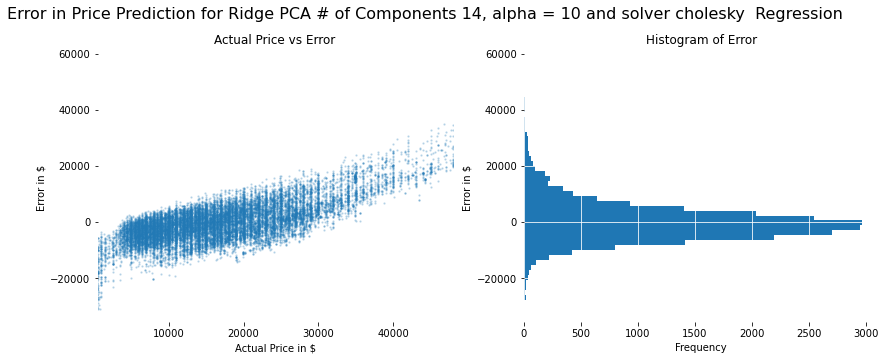

In [140]:
w1= search.best_params_['pca__n_components']
w2 = Ridge_GS.best_params_['alpha']
w3 = Ridge_GS.best_params_['solver']
plt_title= 'Ridge PCA # of Components {}, alpha = {} and solver {} '.format(w1, w2, w3)

pipe_p = search.best_estimator_
y_predict_test_rop, c_ridge_opt_pca = quick_run(pipe_p, X_train_mm, y_train, X_val_mm, y_val, name_g= plt_title)

We graph the predictions using an optimized Ridge Regression vs the actuals

### Looking at the error for Optimized Ridge with PCA

Text(0.5, 0, 'Difference in Price')

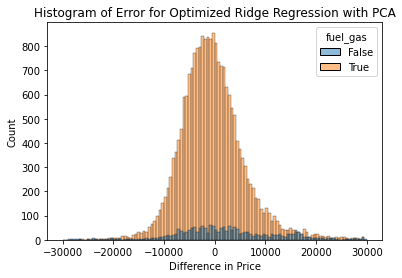

In [141]:
awd = X_val['drive_4wd']

gas = X_val['fuel_gas']==1
diff_pca = y_val- y_predict_test_rop

sns.histplot(x=diff_pca, binrange=[-30000, 30000], hue= gas)
plt.title('Histogram of Error for Optimized Ridge Regression with PCA')
plt.xlabel('Price Prediction Error $')

plt.xlabel('Difference in Price')


In [ ]:
age = X_val['age']
from matplotlib import cm
cmap = cm.get_cmap('viridis')

p= sns.jointplot(x=y_val, y=y_predict_test_rop, kind="kde", xlim= [4000, 70000], hue= age )

p.fig.suptitle("Scatterplot of Ridge regression with PCA  Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


### Calculating Coefficents and it's importance

Next we determine which features have an actual importance. Since we used PCA we find out how much each additional compent helped to explain the data.
We note that it is the first by the time we get to PCA n_components=10 we have explained most of the data

In [ ]:
# Plot the PCA spectrum
pca.fit(X_train_mm)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 20)

plt.tight_layout()
plt.show()


Compare Models

Whe we compare the models we realize that adding PCA if anything decreased the value of the model. Why is this?

In [ ]:
c_data_r =[c_ridge, c_pca_ridge, c_ridge_opt, c_rft, c_ridge_elim, c_ridge_opt_pca]
score_columns= ['Algorithm', 'MAE Train', 'MAE Test',  'MAE Test std', 'MPE Train', 'MPE Test',  'MPE Test std']
convert_dict = {'MAE Train': int, 'MAE Test': int} 
score_tab_r = pd.DataFrame(c_data_r, columns= score_columns )
score_tab_r = score_tab_r.astype(convert_dict) 
pd.options.display.float_format = '{:.4f}'.format
score_tab_r.sort_values('MAE Test')


When we look at the results we see PCA ridge regression is signifvantly worse than non pca. When we look at the scatter  plot of error vs actual we a  1 to 1strongly linear correlation. This suggests that the prediction goes to the median value of price which is not useful.

Feature selection which helps against over fitting. We therefore look at the test score results to see if there is any improvement. There is about a $5 benefit which is unusual. But when we look at what features were eliminated they are often variables within a categorical



In [ ]:

#fig.suptitle('Price vs Price Predicted', fontsize=16, y=1 , x= 0.45)
from matplotlib import cm 
cmap1 = cm.get_cmap('mako')
lim= (200,55000)
g = sns.JointGrid(x=y_val, y=y_predict_test_ridge_opt, space=0, xlim = lim, ylim = lim)
g = g.plot_joint(sns.histplot)
plt.plot([0,55000], [0, 55000], linewidth=0.5, color='red')
g = g.plot_marginals(sns.kdeplot, shade=True, bw_method=0.9)
g.set_axis_labels('Price', 'Predicted Price', fontsize=12)
plt.title("Price vs Price Predicted Optimized no PCA", fontsize=16, x=0, y=1.2)

h = sns.JointGrid(x=y_val, y=y_predict_test_rop, space=0, xlim = lim, ylim = lim)
h = h.plot_joint(sns.histplot, color='lightgreen')
plt.plot([0, 55000], [0, 55000], linewidth=0.5, color='red')
h = h.plot_marginals(sns.kdeplot, shade=True, bw_method=0.9, color='lightgreen')
h.set_axis_labels('price', 'price predicted', fontsize=12)
plt.title("Price vs Price Predicted Optimized with PCA", fontsize=16, y=1.2)


rh = sns.JointGrid(x=y_val, y=y_predict_test_relim, space=0, xlim = lim, ylim = lim)
rh = rh.plot_joint(sns.histplot, color='plum')
plt.plot([0, 55000], [0, 55000], linewidth=0.5, color='green')
rh = rh.plot_marginals(sns.kdeplot, shade=True, bw_method=0.9, color='plum')
rh.set_axis_labels('price', 'price predicted', fontsize=12)
plt.title("Price vs Price Predicted Optimized with reduced features", fontsize=16, y=1.2)

### Choosing the Model aka Concusion
Now we check on how the results of these algorithm compare. Both optimized regressions have a betteer score than the non optimized regression. 

We therefore go with the model that is simpler aka the Ridge without PCA. The data has been less processed and the factors are easier to explain.


In [ ]:
#Forecast for the price of the Tesla 

### Next Steps
    * Redo this study with More MSRP data available
    * Search for other possible variables that correlates with auto price
        * The bias seen in the non ridge regression models shows there is another variable we should be looking for.
    # Search within text description for words that correlate with the need for Craiglist seller need to sell soon.
        * Craig's list sellers are sometimes by time. That would influence price further down.